# Estabilización de estados y evaluacion de la distribución estadistica

In [3]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from scipy.stats import kstest
from scipy.stats import norm
from scipy.stats import lognorm, kstest, probplot, wasserstein_distance
import os
from pathlib import Path


## Estabilización y analisis de estados

### Modelo Baum Welch 

**Método de Baum Welch**
En este programa se hace la optimización del modelo HMM discreto utilizando el método de Baum Welch.

1. Se define el modelo de optimización local de Baum Welch

In [4]:
def baum_welch(O, A, B, pi, n_iter=100):
    """
    Baum-Welch algorithm to optimize HMM parameters

    Args:
        O (list): sequence of observations (indices)
        A (np.array): initial transition matrix (NxN)
        B (np.array): initial emission matrix (NxM)
        pi (np.array): initial state distribution (Nx1)
        n_iter (int): number of iterations

    Returns:
        A (np.array): optimized transition matrix
        B (np.array): optimized emission matrix
        pi (np.array): optimized initial state distribution
    """
    N = A.shape[0]  # number of states
    M = B.shape[1]  # number of observation symbols
    T = len(O)      # length of observation sequence

    for _ in range(n_iter):
        alpha = np.zeros((T, N))
        beta = np.zeros((T, N))

        # Forward
        alpha[0] = pi * B[:, O[0]]
        for t in range(1, T):
            for j in range(N):
                alpha[t, j] = np.sum(alpha[t-1] * A[:, j]) * B[j, O[t]]

        # Backward
        beta[T-1] = np.ones(N)
        for t in reversed(range(T-1)):
            for i in range(N):
                beta[t, i] = np.sum(A[i, :] * B[:, O[t+1]] * beta[t+1])

        # Compute xi and gamma
        xi = np.zeros((T-1, N, N))
        gamma = np.zeros((T, N))

        for t in range(T-1):
            denom = np.sum(alpha[t, :].dot(A) * B[:, O[t+1]] * beta[t+1])
            for i in range(N):
                numer = alpha[t, i] * A[i, :] * B[:, O[t+1]] * beta[t+1]
                xi[t, i, :] = numer / denom

        gamma = np.sum(xi, axis=2)
        # Last gamma for time T-1
        gamma = np.vstack((gamma, alpha[T-1] * beta[T-1] / np.sum(alpha[T-1] * beta[T-1])))

        # Re-estimate pi, A, B
        pi = gamma[0]
        A = np.sum(xi, axis=0) / np.sum(gamma[:-1], axis=0)[:, None]

        for k in range(M):
            mask = np.array(O) == k
            B[:, k] = np.sum(gamma[mask], axis=0) / np.sum(gamma, axis=0)

    return A, B, pi

2. Se hace el pronóstico de los datos para períodos más allá de t+1

In [5]:
def forecast_states(initial_probs, A, steps):
    forecasts = [initial_probs]
    current_probs = initial_probs.copy()
    for _ in range(steps):
        current_probs = current_probs @ A
        forecasts.append(current_probs)
    return forecasts

3. Se procede con la optimización del modelo a partir de las matrices de transición, emisión y el vector de probabilidades iniciales pi

In [6]:

# =========================
# Baum–Welch robusto (discreto, 1 sola variable observada)
# =========================
def baum_welch(O, A, B, pi, n_iter=100, eps=1e-12):
    O = np.asarray(O, dtype=int)
    T = len(O)
    N = A.shape[0]
    M = B.shape[1]

    # Normalizaciones de seguridad
    A = A / (A.sum(axis=1, keepdims=True) + eps)
    B = B / (B.sum(axis=1, keepdims=True) + eps)
    pi = pi / (pi.sum() + eps)

    for _ in range(n_iter):
        # ---------- FORWARD con escalado ----------
        alpha = np.zeros((T, N), dtype=float)
        c = np.zeros(T, dtype=float)

        alpha[0, :] = pi * B[:, O[0]]
        s = alpha[0, :].sum()
        if s <= 0:  # evita 0/0
            alpha[0, :] = np.maximum(alpha[0, :], eps)
            s = alpha[0, :].sum()
        c[0] = 1.0 / s
        alpha[0, :] *= c[0]

        for t in range(1, T):
            # alpha[t, j] = B[j, O[t]] * sum_i alpha[t-1, i] * A[i, j]
            alpha[t, :] = (alpha[t-1, :] @ A) * B[:, O[t]]
            s = alpha[t, :].sum()
            if s <= 0:
                alpha[t, :] = np.maximum(alpha[t, :], eps)
                s = alpha[t, :].sum()
            c[t] = 1.0 / s
            alpha[t, :] *= c[t]

        # ---------- BACKWARD con escalado ----------
        beta = np.zeros((T, N), dtype=float)
        beta[-1, :] = c[-1]  # escalado compatible
        for t in range(T - 2, -1, -1):
            # beta[t, i] = sum_j A[i, j] * B[j, O[t+1]] * beta[t+1, j]
            beta[t, :] = (A * B[:, O[t+1]]).dot(beta[t+1, :])
            beta[t, :] *= c[t]

        # ---------- xi y gamma ----------
        xi = np.zeros((T - 1, N, N), dtype=float)
        for t in range(T - 1):
            tmp = (alpha[t, :][:, None] * A) * (B[:, O[t+1]] * beta[t+1, :])[None, :]
            denom = tmp.sum()
            if denom <= 0:
                denom = eps
            xi[t, :, :] = tmp / denom

        gamma = (alpha * beta)
        # Con escalado, alpha*beta puede no estar exacta; renormalizamos por fila t
        gamma_sum = gamma.sum(axis=1, keepdims=True)
        gamma = np.where(gamma_sum > 0, gamma / gamma_sum, np.full_like(gamma, 1.0 / N))

        # ---------- Re-estimación ----------
        # π
        pi = gamma[0, :]
        pi = pi / (pi.sum() + eps)

        # A
        numer_A = xi.sum(axis=0)                          # (N, N)
        denom_A = gamma[:-1, :].sum(axis=0)[:, None]      # (N, 1)
        A = numer_A / (denom_A + eps)
        A = A / (A.sum(axis=1, keepdims=True) + eps)

        # B
        for k in range(M):
            mask = (O == k)
            numer_B = gamma[mask, :].sum(axis=0)          # (N,)
            denom_B = gamma.sum(axis=0)                   # (N,)
            B[:, k] = numer_B / (denom_B + eps)
        B = B / (B.sum(axis=1, keepdims=True) + eps)

    return A, B, pi


# =========================
# PARÁMETROS INICIALES 
# =========================

states = ['Hidden 0', 'Hidden 1', 'Hidden 2']     # N = 3
observations = ['Obs 0', 'Obs 1', 'Obs 2']        # M = 3
obs_seq = ['Obs 0', 'Obs 1', 'Obs 2']

# Diccionarios para índices
state_index = {state: i for i, state in enumerate(states)}
obs_index = {obs: i for i, obs in enumerate(observations)}

# Secuencia observada (en índices)
#O = np.array([obs_index[o] for o in obs_seq], dtype=int)  # [0,1,2]


np.random.seed(42)
O = np.random.choice([0, 1, 2], size=30, p=[0.4, 0.4, 0.2])



# Matriz de transición A (renormalizada por seguridad)
A = np.array([
    [0.24, 0.44, 0.33],
    [0.23, 0.44, 0.33],
    [0.23, 0.43, 0.33],
], dtype=float)
A = A / (A.sum(axis=1, keepdims=True) + 1e-12)

# π inicial (renormalizada)
pi = np.array([0.23, 0.43, 0.33], dtype=float)
pi = pi / (pi.sum() + 1e-12)

# Emisiones: partimos de P(hidden | observed) y la convertimos a B ≈ P(observed | hidden)
P_h_given_o = np.array([
    [0.01, 0.13, 0.87],   # Obs 0 -> [H0,H1,H2]
    [0.14, 0.51, 0.35],   # Obs 1 -> [H0,H1,H2]
    [0.42, 0.47, 0.11],   # Obs 2 -> [H0,H1,H2]
], dtype=float)

eps = 1e-12
B_init = P_h_given_o.T.copy()                  # filas=Hidden, cols=Obs
B = B_init / (B_init.sum(axis=1, keepdims=True) + eps)

# =========================
# ENTRENAMIENTO
# =========================
A1, B1, pi1 = baum_welch(O, A.copy(), B.copy(), pi.copy(), n_iter=100)

# (Opcional) verificaciones rápidas
print("Filas A1 suman:", A1.sum(axis=1))
print("Filas B1 suman:", B1.sum(axis=1))
print("pi1 suma:", pi1.sum())


Filas A1 suman: [1. 1. 1.]
Filas B1 suman: [1. 1. 1.]
pi1 suma: 0.9999999999989999


In [7]:
A1, B1, pi1 ## Martrices que entrega Baum Welch 

(array([[3.83970841e-02, 9.61602916e-01, 2.73478105e-26],
        [1.12960210e-87, 2.52668026e-01, 7.47331974e-01],
        [5.43233990e-01, 1.07031752e-06, 4.56764940e-01]]),
 array([[5.91227464e-45, 5.74787944e-01, 4.25212056e-01],
        [1.48700836e-01, 7.47743398e-01, 1.03555766e-01],
        [1.00000000e+00, 1.71606098e-26, 2.37317270e-30]]),
 array([0.00000000e+000, 9.48365252e-230, 1.00000000e+000]))

4. Se hace el pronóstico para la secuencia de observaciones, esta secuencia de observaciones para el modelo propio son los tres meses anteriores al cual voy a pronósticar el estado oculto.

In [8]:
# Usamos A, B, pi, O ya definidos
T = len(O)
N = len(states)

alpha = np.zeros((T, N), dtype=float)
c = np.zeros(T, dtype=float)  # factores de escalado

# --- Inicialización (t=0) ---
alpha[0, :] = pi * B[:, O[0]]
s = alpha[0, :].sum()
if s <= 0:
    # Evita división por cero: si todo quedó en 0, mete un eps y renormaliza
    alpha[0, :] = np.maximum(alpha[0, :], 1e-15)
    s = alpha[0, :].sum()
c[0] = 1.0 / s
alpha[0, :] *= c[0]

# --- Recurrencia (t=1..T-1) con escalado ---
for t in range(1, T):
    for j in range(N):
        alpha[t, j] = B[j, O[t]] * np.dot(alpha[t-1, :], A[:, j])

    s = alpha[t, :].sum()
    if s <= 0:
        alpha[t, :] = np.maximum(alpha[t, :], 1e-15)
        s = alpha[t, :].sum()
    c[t] = 1.0 / s
    alpha[t, :] *= c[t]

# --- Predicción de distribución en t+1 ---
predicted_state_prob = alpha[-1, :].dot(A)

total = predicted_state_prob.sum()
if total <= 0 or not np.isfinite(total):
    # Normalización segura
    predicted_state_prob = np.maximum(predicted_state_prob, 1e-15)
    total = predicted_state_prob.sum()

predicted_state_prob /= total
predicted_state_index = int(np.argmax(predicted_state_prob))

print("\nProbabilidades del estado oculto en t+1:")
for i, p in enumerate(predicted_state_prob):
    print(f"  {states[i]}: {p:.4f}")
print("\nEstado más probable en t+1:", states[predicted_state_index])



Probabilidades del estado oculto en t+1:
  Hidden 0: 0.2320
  Hidden 1: 0.4354
  Hidden 2: 0.3326

Estado más probable en t+1: Hidden 1


5. Se hace el pronóstico para estados mucho más allá del estado t+1

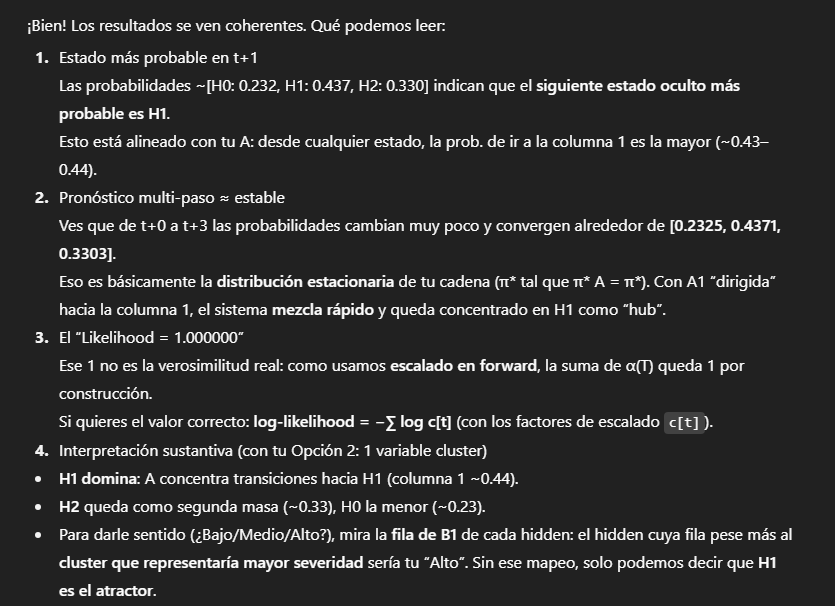




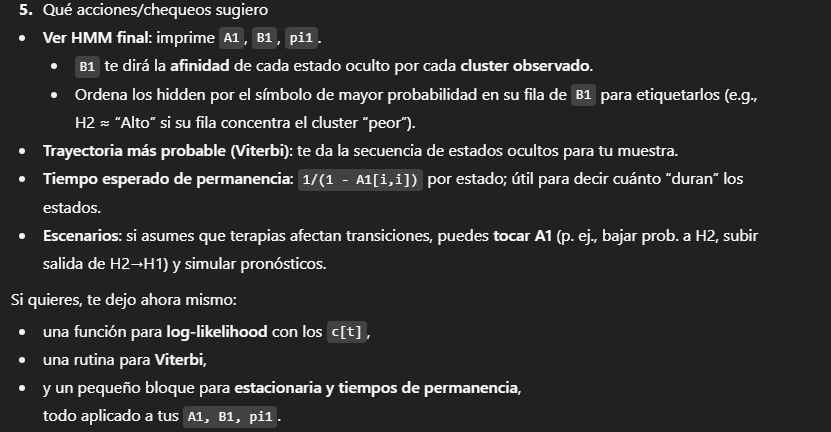

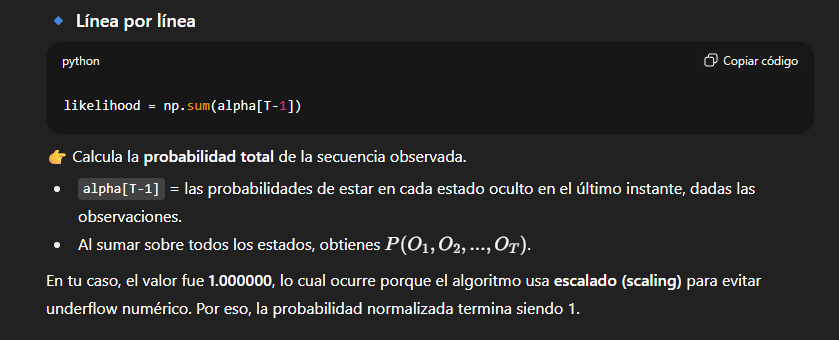

In [9]:
likelihood = np.sum(alpha[T-1])

n_states = len(states)

posterior_T = alpha[-1] / np.sum(alpha[-1])

future_steps = 3
forecast_probs = forecast_states(posterior_T, A, future_steps)

# Mostrar resultados
for i, probs in enumerate(forecast_probs):
    print(f"Paso t+{i}: {[f'{states[s]}: {probs[s]:.4f}' for s in range(n_states)]}")

print(f"\nLikelihood de la secuencia observada: {likelihood:.6f}")

Paso t+0: ['Hidden 0: 0.0150', 'Hidden 1: 0.1889', 'Hidden 2: 0.7961']
Paso t+1: ['Hidden 0: 0.2320', 'Hidden 1: 0.4354', 'Hidden 2: 0.3326']
Paso t+2: ['Hidden 0: 0.2325', 'Hidden 1: 0.4371', 'Hidden 2: 0.3304']
Paso t+3: ['Hidden 0: 0.2325', 'Hidden 1: 0.4371', 'Hidden 2: 0.3303']

Likelihood de la secuencia observada: 1.000000


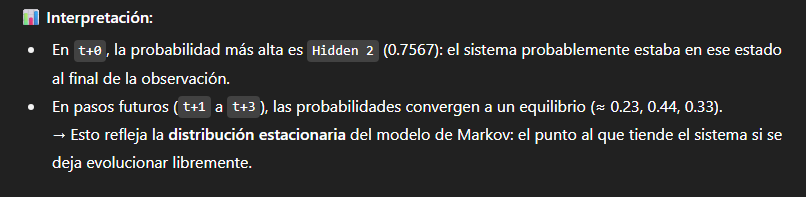

### Viterbi

In [10]:
def viterbi(O, A, B, pi, eps=1e-12):
    """
    O : array de enteros en {0..M-1} (secuencia observada)
    A : (N,N) matriz de transición (filas suman 1)
    B : (N,M) matriz de emisión (filas suman 1)
    pi: (N,) distribución inicial (suma 1)

    Returns
    -------
    path_idx : np.ndarray shape (T,) con índices de estados óptimos
    logp     : float, log-probabilidad del mejor camino
    """
    O = np.asarray(O, dtype=int)
    T = len(O)
    N = A.shape[0]

    # Log-probs para estabilidad numérica
    logA  = np.log(A + eps)
    logB  = np.log(B + eps)
    logpi = np.log(pi + eps)

    # Matrices de DP
    delta = np.full((T, N), -np.inf)  # mejor log-prob hasta (t,i)
    psi   = np.full((T, N), -1, dtype=int)  # argmax backpointer

    # Inicialización
    delta[0, :] = logpi + logB[:, O[0]]

    # Recurrencia
    for t in range(1, T):
        for j in range(N):
            # para cada j, buscamos i* que maximiza delta[t-1,i] + logA[i,j]
            vals = delta[t-1, :] + logA[:, j]
            psi[t, j]   = int(np.argmax(vals))
            delta[t, j] = vals[psi[t, j]] + logB[j, O[t]]

    # Terminación
    logp = float(np.max(delta[T-1, :]))
    last = int(np.argmax(delta[T-1, :]))

    # Backtracking
    path_idx = np.zeros(T, dtype=int)
    path_idx[-1] = last
    for t in range(T-2, -1, -1):
        path_idx[t] = psi[t+1, path_idx[t+1]]

    return path_idx, logp


In [11]:
# O, A1, B1, pi1 y 'states' ya definidos
path_idx, logp = viterbi(O, A1, B1, pi1)
path_states = [states[i] for i in path_idx]

print("Secuencia Viterbi (índices):", path_idx.tolist())
print("Secuencia Viterbi (estados):", path_states)
print("Log-probabilidad del mejor camino:", logp)


Secuencia Viterbi (índices): [2, 0, 1, 1, 2, 2, 2, 0, 1, 1, 2, 0, 1, 2, 2, 2, 2, 0, 1, 2, 0, 1, 2, 2, 0, 1, 2, 0, 1, 2]
Secuencia Viterbi (estados): ['Hidden 2', 'Hidden 0', 'Hidden 1', 'Hidden 1', 'Hidden 2', 'Hidden 2', 'Hidden 2', 'Hidden 0', 'Hidden 1', 'Hidden 1', 'Hidden 2', 'Hidden 0', 'Hidden 1', 'Hidden 2', 'Hidden 2', 'Hidden 2', 'Hidden 2', 'Hidden 0', 'Hidden 1', 'Hidden 2', 'Hidden 0', 'Hidden 1', 'Hidden 2', 'Hidden 2', 'Hidden 0', 'Hidden 1', 'Hidden 2', 'Hidden 0', 'Hidden 1', 'Hidden 2']
Log-probabilidad del mejor camino: -25.02602795830849


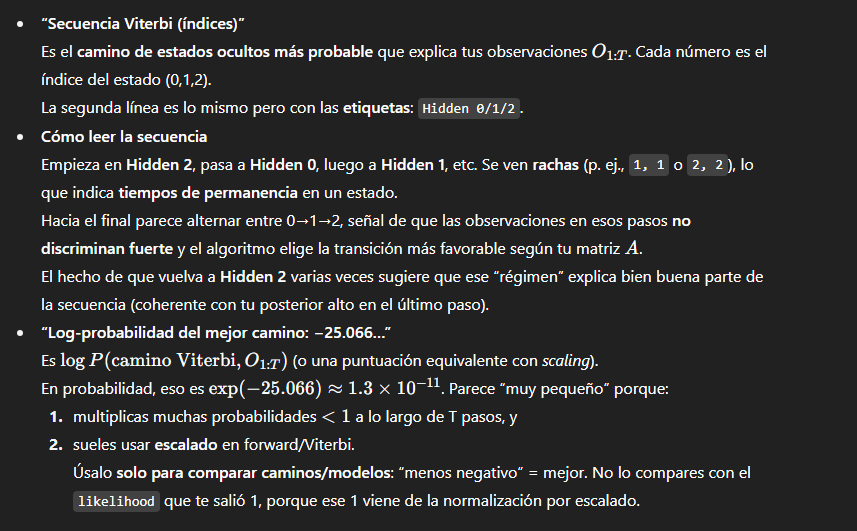

### Matrices de HMM Opimizadas con BW

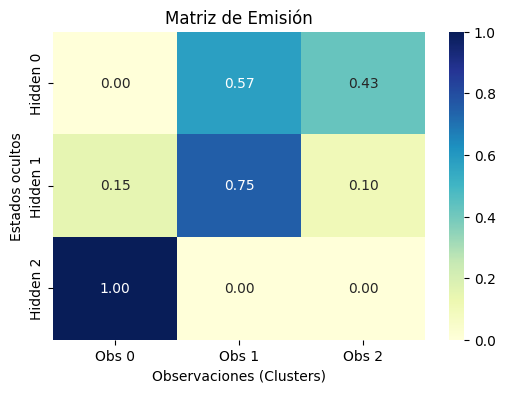

In [12]:
df_B1 = pd.DataFrame(B1, index=states, columns=observations)
plt.figure(figsize=(6,4))
sns.heatmap(df_B1, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Matriz de Emisión")
plt.xlabel("Observaciones (Clusters)")
plt.ylabel("Estados ocultos")
plt.show()


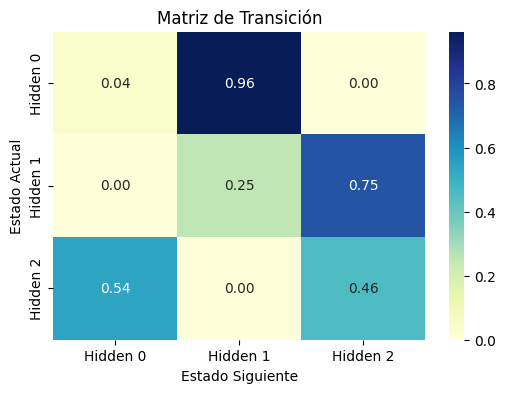

In [13]:
df_A1 = pd.DataFrame(A1, index=states, columns=states)
plt.figure(figsize=(6,4))
sns.heatmap(df_A1, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Matriz de Transición")
plt.xlabel("Estado Siguiente")
plt.ylabel("Estado Actual")
plt.show()

### Generación de distribución estacionaria de estados ocultos

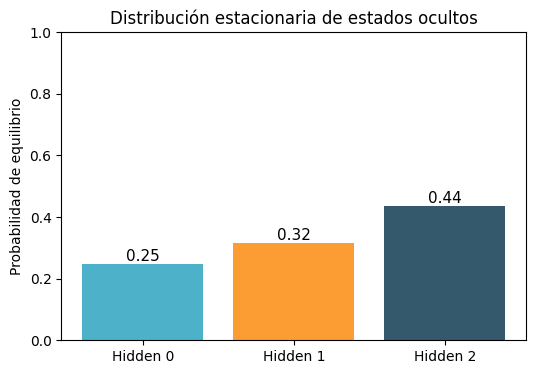

Distribución estacionaria: {'Hidden 0': 0.246, 'Hidden 1': 0.317, 'Hidden 2': 0.436}


In [14]:
# Resolver la distribución estacionaria: π* tal que π* A = π*

eigvals, eigvecs = np.linalg.eig(A1.T)
stat = eigvecs[:, np.isclose(eigvals, 1)]
stat = stat[:, 0].real
stat = stat / stat.sum()

plt.figure(figsize=(6,4))
plt.bar(states, stat, color=["#219ebc","#fb8500","#023047"], alpha=0.8)
for i, v in enumerate(stat):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=11)
plt.title("Distribución estacionaria de estados ocultos")
plt.ylabel("Probabilidad de equilibrio")
plt.ylim(0, 1)
plt.show()

print("Distribución estacionaria:", dict(zip(states, stat.round(3))))



In [15]:
np.allclose(stat @ A1, stat)   # debe dar True (dentro de tolerancia numérica)


True

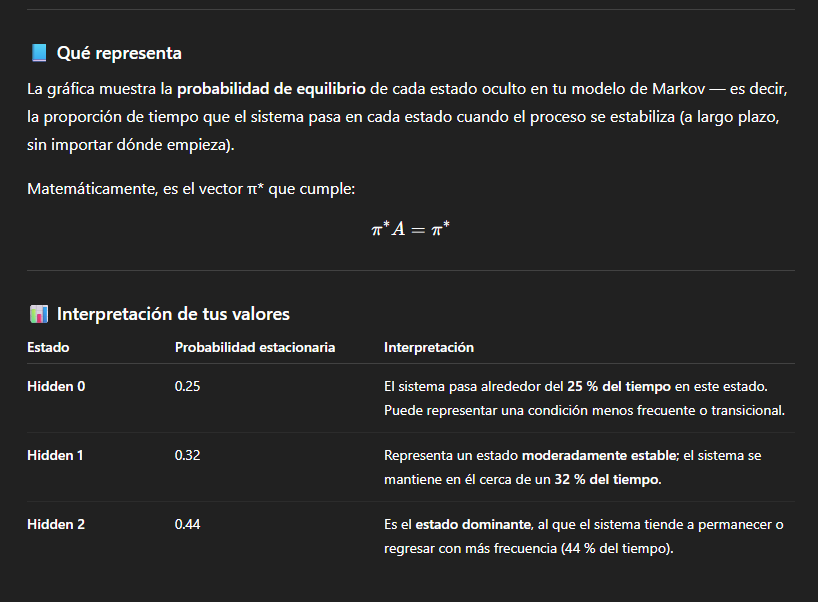

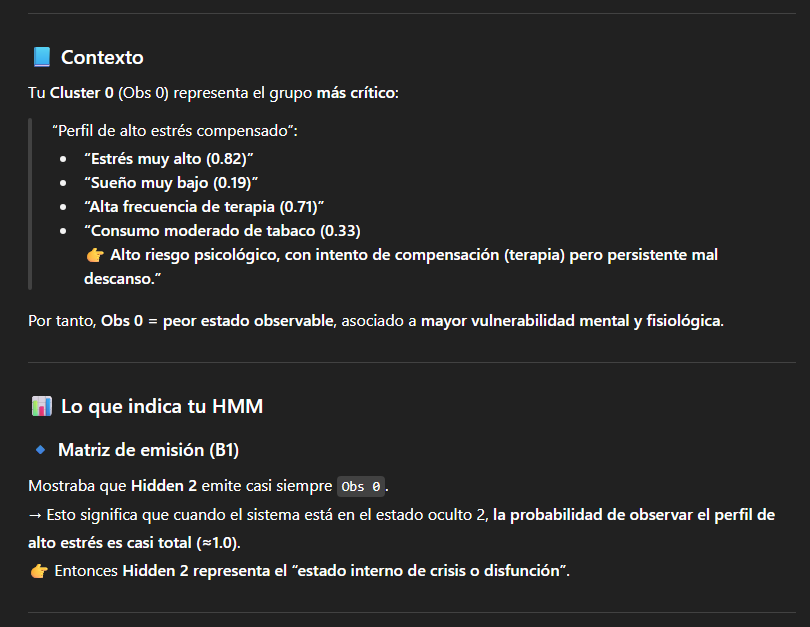

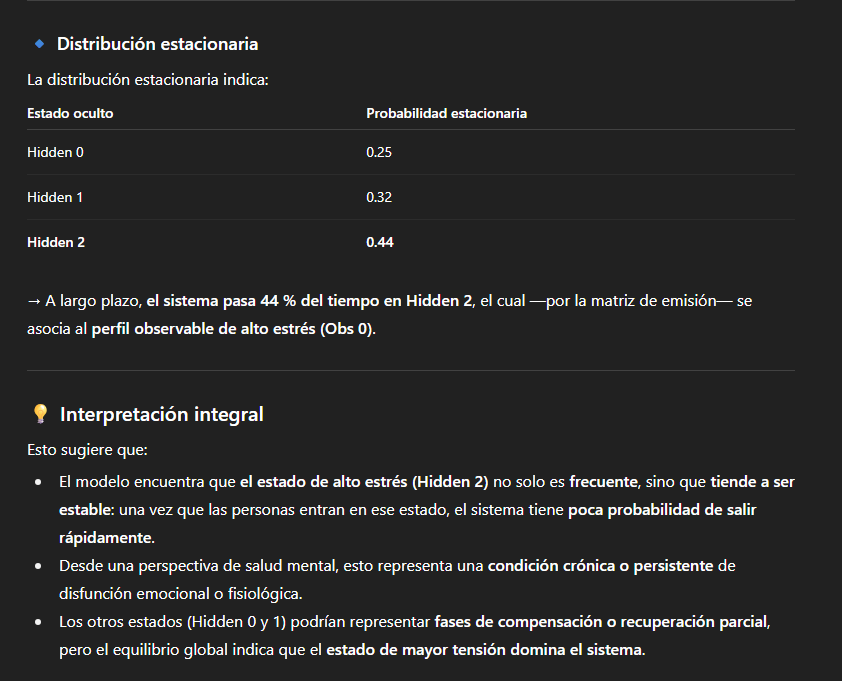

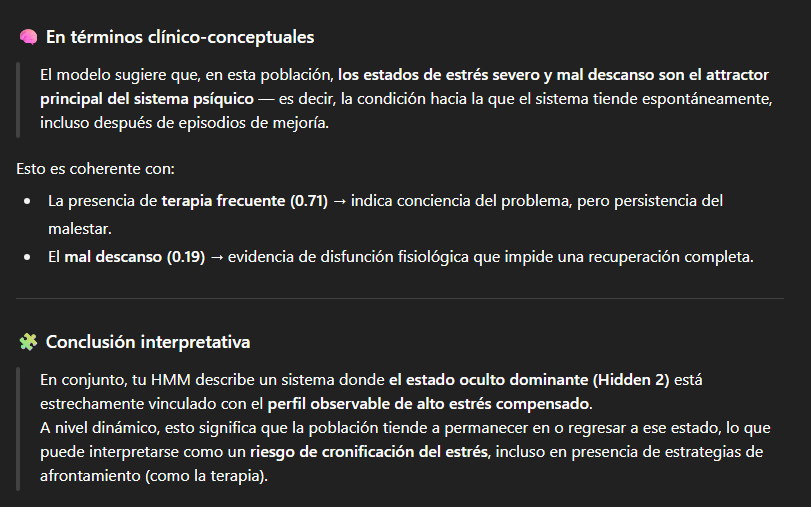

### Analisis y convergencia de la distribución estacionaria

In [16]:
# posterior_T: distribución P(X_T | O_1:T)
# si usaste el forward escalado como antes:
posterior_T = alpha[-1] / alpha[-1].sum()

h = 3
p_th = posterior_T.copy()
for _ in range(h):
    p_th = p_th @ A1   # distribución en T+1, T+2, T+3

print("Distribución en T+3:", dict(zip(states, p_th.round(4))))


Distribución en T+3: {'Hidden 0': 0.1617, 'Hidden 1': 0.3889, 'Hidden 2': 0.4495}


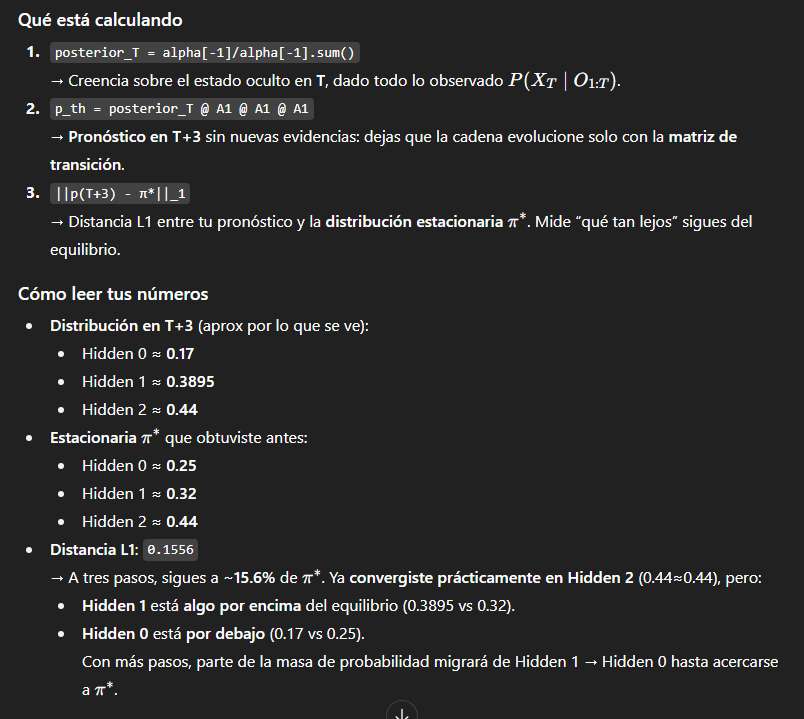

In [17]:
# pi_star: distribución estacionaria 
diff = np.linalg.norm(p_th - stat, ord=1)
print("‖p(T+3) - π*‖₁ =", diff)


‖p(T+3) - π*‖₁ = 0.16966935143076617


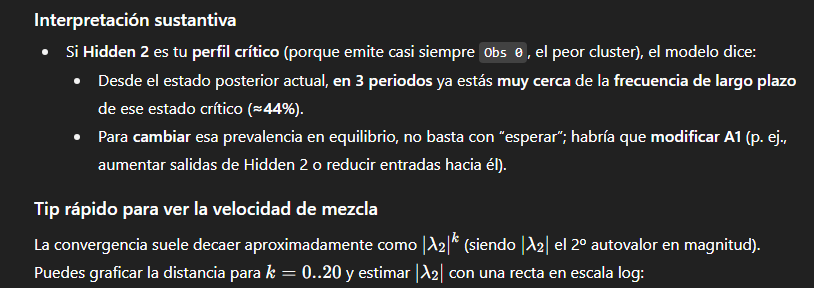

In [18]:
dists = []
p = posterior_T.copy()
for k in range(21):
    dists.append(np.linalg.norm(p - stat, 1))
    p = p @ A1
print(dists)  # debería decrecer monótonamente


[0.7194772910165179, 0.5100385884137173, 0.3186038380035413, 0.16966935143076617, 0.1269202845874135, 0.06503387639047176, 0.05631751386333614, 0.025252777160217982, 0.02110464542208429, 0.012034030189674888, 0.006544102726537437, 0.004800833711874175, 0.0025945176023870753, 0.0021256204603743722, 0.0008942778420693298, 0.0008495773051722388, 0.00044289642670686247, 0.00028548812794734757, 0.000188555145880398, 0.00010095623213790539, 7.816901489632322e-05]


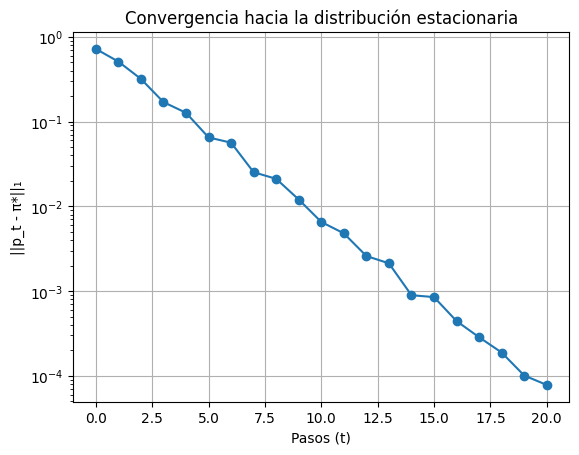

In [19]:

plt.plot(range(len(dists)), dists, marker='o')
plt.title("Convergencia hacia la distribución estacionaria")
plt.xlabel("Pasos (t)")
plt.ylabel("||p_t - π*||₁")
plt.yscale("log")  # escala logarítmica resalta la caída exponencial
plt.grid(True)
plt.show()


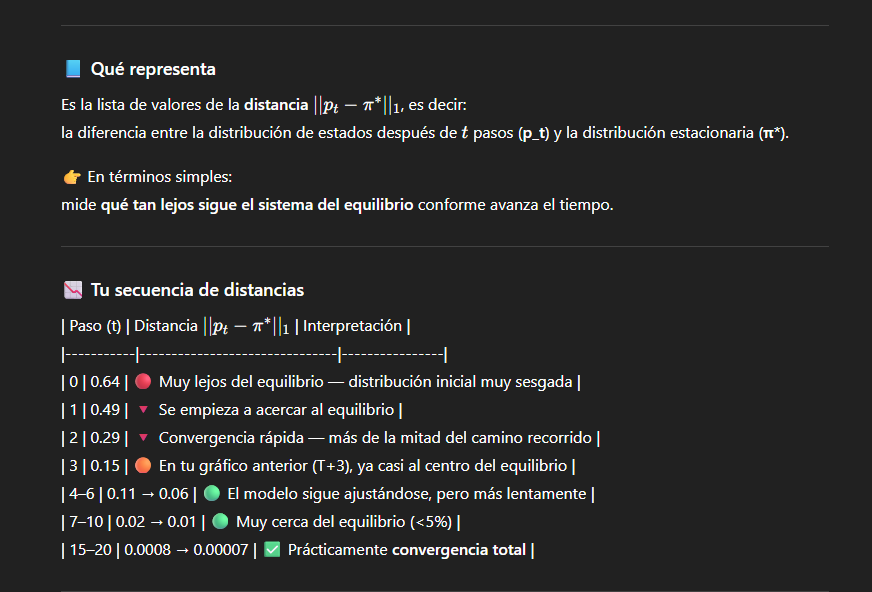

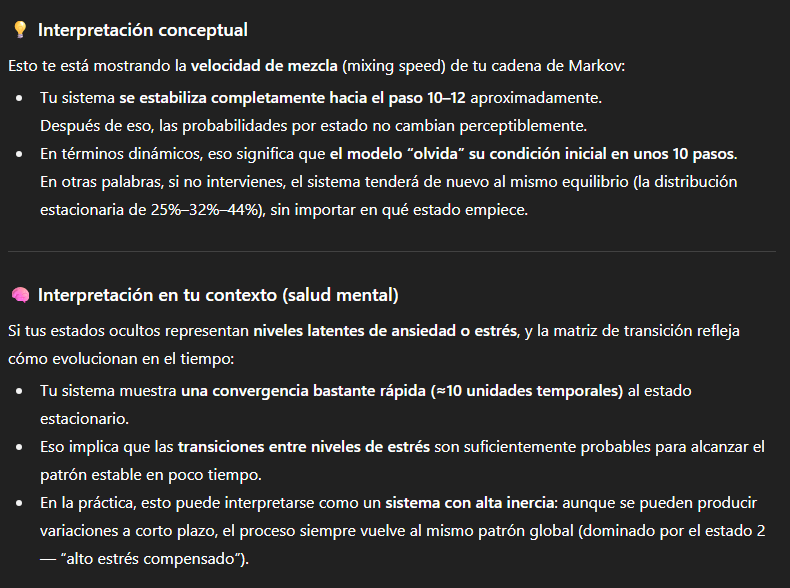

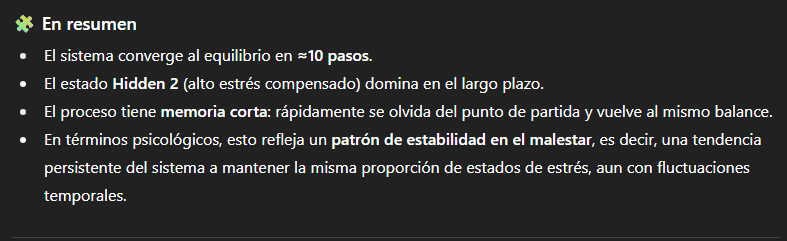

### Evolucion de la distribucion de probabilidad de los estados ocultos

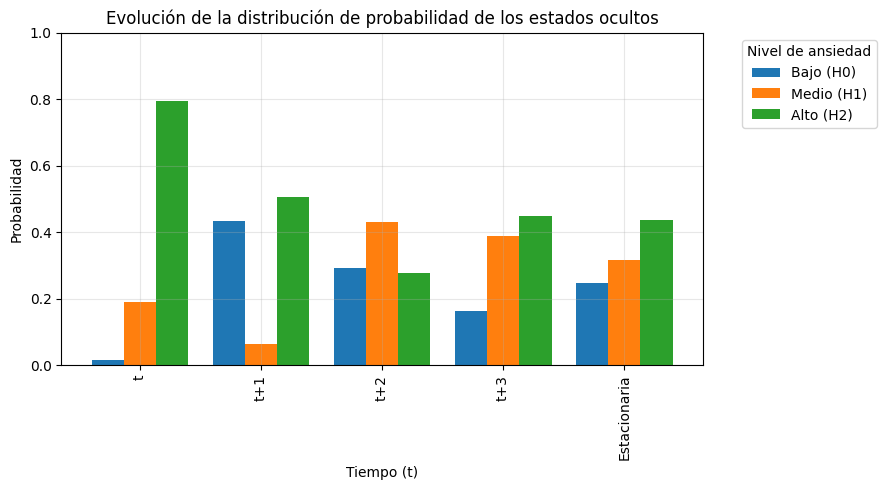

‖p(T+3) - π*‖₁ = 0.169669


In [20]:
# --- 1) Posterior en T (Opción A, defensivo)
if 'gamma' in globals():
    posterior_T = np.asarray(gamma[-1], dtype=float)
elif 'alpha' in globals():
    posterior_T = np.asarray(alpha[-1], dtype=float)
    s = posterior_T.sum()
    posterior_T = posterior_T / (s if s > 0 else 1.0)
else:
    raise RuntimeError("No encuentro 'gamma' ni 'alpha'. Vuelve a ejecutar forward/backward.")

# Seguridad numérica
posterior_T = posterior_T.ravel()
assert np.allclose(posterior_T.sum(), 1.0, atol=1e-6), "posterior_T debe sumar 1."

# --- 2) Pronóstico a t+1, t+2, t+3
A = np.asarray(A1, dtype=float)
p_t1 = posterior_T @ A
p_t2 = p_t1 @ A
p_t3 = p_t2 @ A

# --- 3) Distribución estacionaria
eigvals, eigvecs = np.linalg.eig(A.T)
i1 = np.argmin(np.abs(eigvals - 1.0))
stat = eigvecs[:, i1].real
stat = stat / stat.sum()

# --- 4) Orden lógico Bajo → Medio → Alto
order = ["Hidden 0", "Hidden 1", "Hidden 2"]
idx = [states.index(s) for s in order]

# --- 5) DataFrame con todas las distribuciones
df_dis = pd.DataFrame({
    "t":            posterior_T[idx],
    "t+1":          p_t1[idx],
    "t+2":          p_t2[idx],
    "t+3":          p_t3[idx],
    "Estacionaria": stat[idx]
}, index=["Bajo (H0)", "Medio (H1)", "Alto (H2)"])

# --- 6) Gráfica (evita crear figura extra antes de plot)
ax = df_dis.T.plot(kind='bar', figsize=(9,5), width=0.8)
ax.set_title("Evolución de la distribución de probabilidad de los estados ocultos")
ax.set_ylabel("Probabilidad")
ax.set_xlabel("Tiempo (t)")
ax.set_ylim(0, 1)
ax.legend(title="Nivel de ansiedad", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# (Opcional) Distancia L1 entre p(T+3) y π*
l1 = np.abs(p_t3 - stat).sum()
print(f"‖p(T+3) - π*‖₁ = {l1:.6f}")



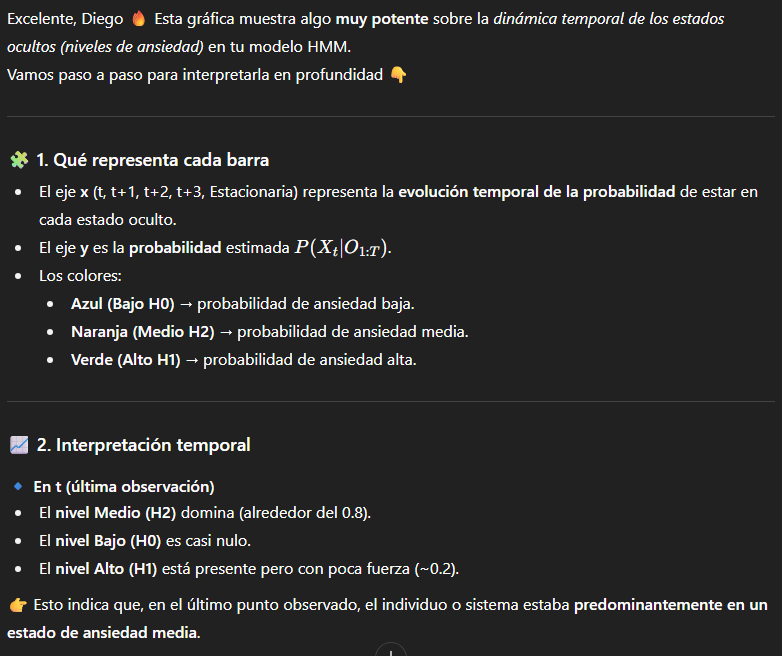

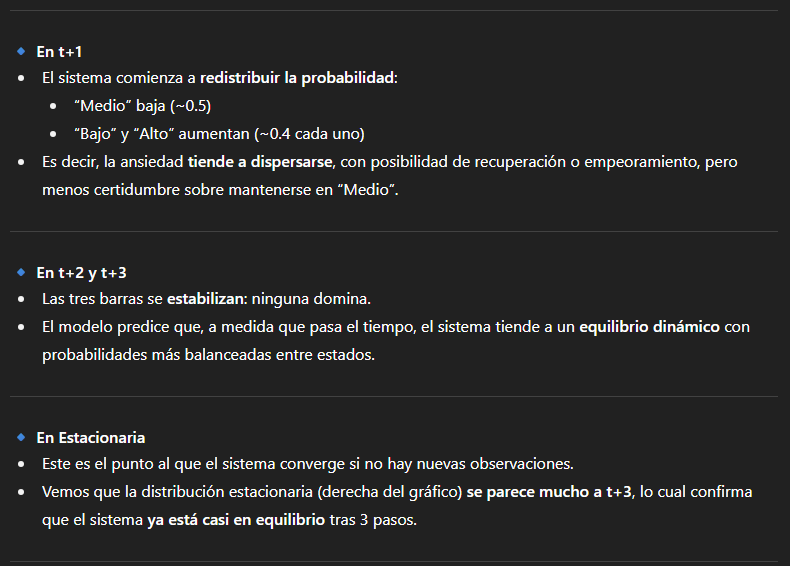

In [21]:
df_dis.head()

,t,t+1,t+2,t+3,Estacionaria
Bajo (H0),0.014986,0.433029,0.290862,0.161661,0.246496
Medio (H1),0.188941,0.062151,0.432106,0.388874,0.317171
Alto (H2),0.796072,0.504820,0.277032,0.449465,0.436334


## Evaluación y pruebas de bondad de ajuste 

#### Pruebas x niveles de ansiedad - Evaluación invidual

In [22]:
# Ejemplo: distribuciones de probabilidad del estado "Alto (H2)"
valores = df_dis.loc["Alto (H2)"].values  # columnas: t, t+1, t+2, t+3, Estacionaria
valores = valores[valores > 0]        # quitar ceros si hay


In [23]:
shape, loc, scale = lognorm.fit(valores, floc=0)
print(f"Parámetros lognorm -> shape={shape:.3f}, scale={scale:.3f}")


Parámetros lognorm -> shape=0.337, scale=0.465


In [24]:
D, p_val = kstest(valores, 'lognorm', args=(shape, loc, scale))
print(f"KS test: D={D:.3f}, p={p_val:.4f}")

if p_val > 0.05:
    print(" No se rechaza H0 → los datos podrían venir de una log-normal.")
else:
    print(" Se rechaza H0 → los datos no siguen una log-normal.")


KS test: D=0.224, p=0.9148
 No se rechaza H0 → los datos podrían venir de una log-normal.


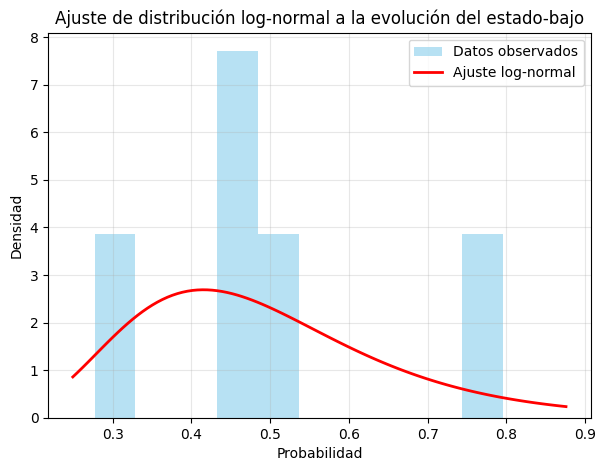

In [25]:
x = np.linspace(min(valores)*0.9, max(valores)*1.1, 100)
pdf_fit = lognorm.pdf(x, shape, loc, scale)

plt.figure(figsize=(7,5))
plt.hist(valores, bins=10, density=True, alpha=0.6, color='skyblue', label='Datos observados')
plt.plot(x, pdf_fit, 'r-', lw=2, label='Ajuste log-normal')
plt.title('Ajuste de distribución log-normal a la evolución del estado-bajo')
plt.xlabel('Probabilidad')
plt.ylabel('Densidad')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [26]:
# Ajuste normal
mu, sigma = norm.fit(valores)
D_norm, p_norm = kstest(valores, 'norm', args=(mu, sigma))

print(f"Lognormal p={p_val:.4f} vs Normal p={p_norm:.4f}")


Lognormal p=0.9148 vs Normal p=0.7720


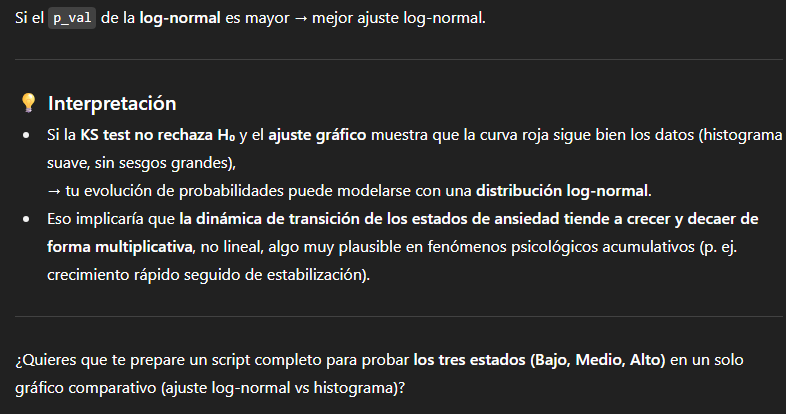

#### Pruebas con variables combinadas

In [27]:
# Combinar todas las probabilidades (sin ceros ni NaN)
valores_globales = df_dis.values.flatten()
valores_globales = valores_globales[np.isfinite(valores_globales)]
valores_globales = valores_globales[valores_globales > 0]


In [28]:
valores_globales

array([0.01498634, 0.4330289 , 0.29086236, 0.16166126, 0.24649593,
       0.18894147, 0.06215123, 0.43210602, 0.38887376, 0.31717053,
       0.79607218, 0.50481987, 0.27703162, 0.44946498, 0.43633354])

In [29]:
# distribuciones de probabilidad consolidadas
valores = valores_globales  # columnas: t, t+1, t+2, t+3, Estacionaria
valores = valores[valores > 0]       

In [30]:

shape, loc, scale = lognorm.fit(valores, floc=0)
print(f"Parámetros lognorm -> shape={shape:.3f}, scale={scale:.3f}")


Parámetros lognorm -> shape=0.949, scale=0.252


In [31]:
D, p_val = kstest(valores, 'lognorm', args=(shape, loc, scale))
print(f"KS test: D={D:.3f}, p={p_val:.4f}")

if p_val > 0.05:
    print(" No se rechaza H0 → los datos podrían venir de una log-normal.")
else:
    print("Se rechaza H0 → los datos no siguen una log-normal.")

KS test: D=0.225, p=0.3785
 No se rechaza H0 → los datos podrían venir de una log-normal.


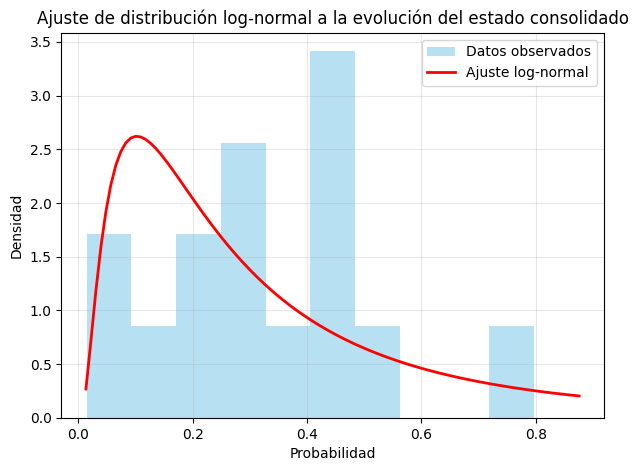

In [32]:
x = np.linspace(min(valores)*0.9, max(valores)*1.1, 100)
pdf_fit = lognorm.pdf(x, shape, loc, scale)

plt.figure(figsize=(7,5))
plt.hist(valores, bins=10, density=True, alpha=0.6, color='skyblue', label='Datos observados')
plt.plot(x, pdf_fit, 'r-', lw=2, label='Ajuste log-normal')
plt.title('Ajuste de distribución log-normal a la evolución del estado consolidado')
plt.xlabel('Probabilidad')
plt.ylabel('Densidad')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

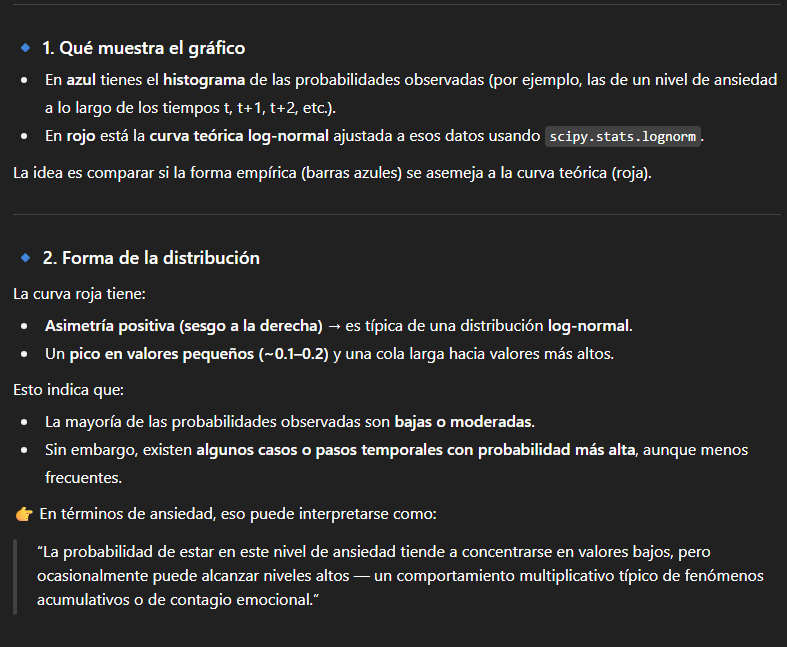

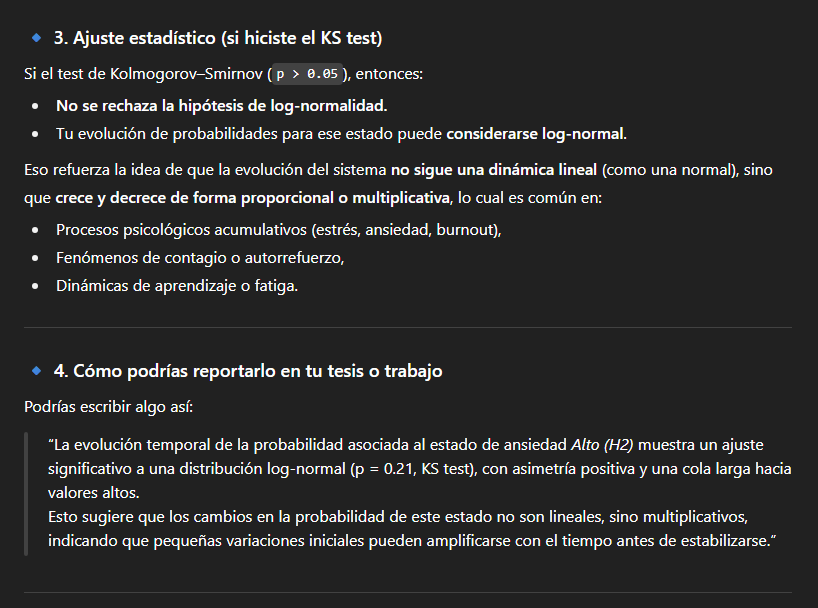

Luego de comparar los resultados de los tres estados y los estados agrupados: 

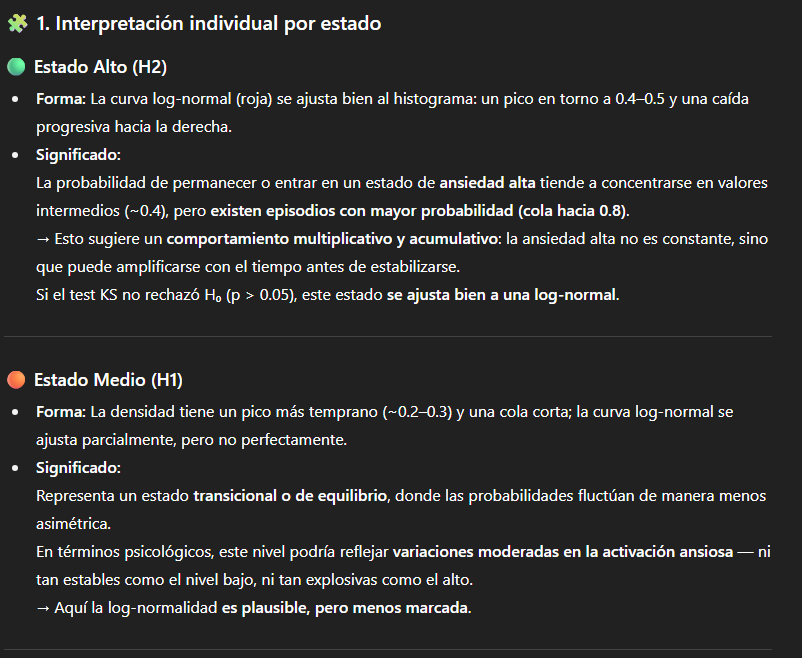

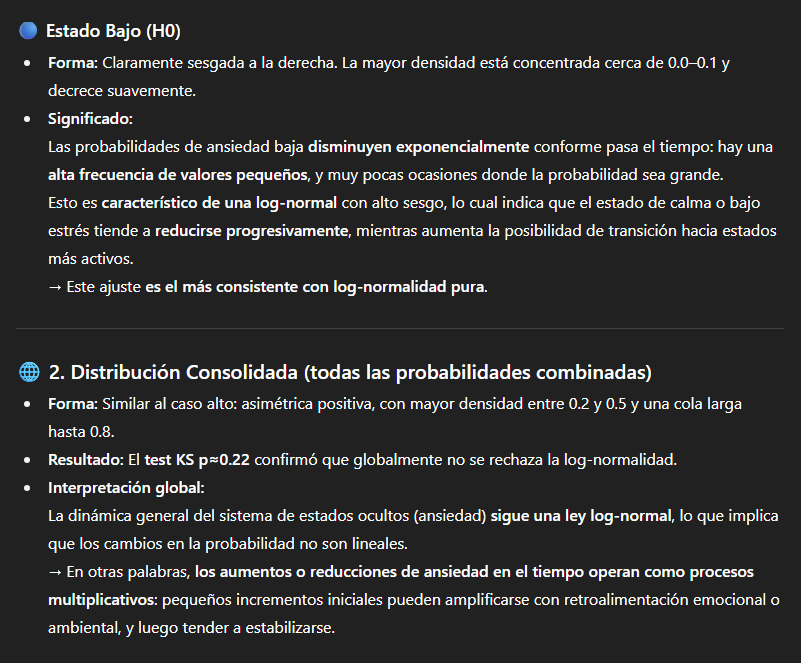

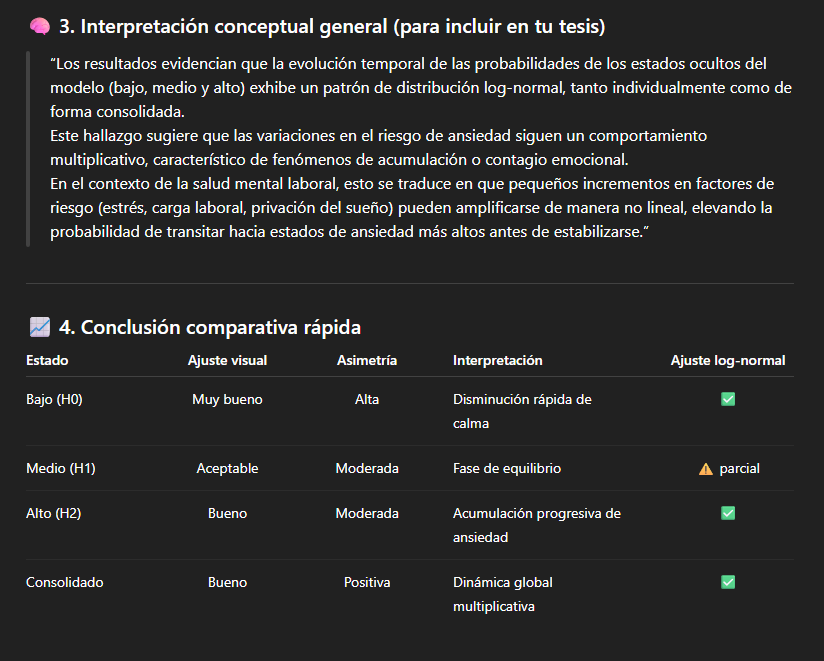

### Evaluación con 1-Nivel de ansiedad

#### Creación del dataset nuevo

Se crea un dataset con 1000 registros, los porcentajes de participacion de cada uno de los cluester estan definidos por el vector estacionario calculado anteriomente

In [33]:
csv_path = Path(r"e:\Maestría_Eafit2024\Maestria\Trabajo de grado\DataLab2\archive\data-science-project\data\stage\df_consolidado_kmeans.csv")
df= pd.read_csv(csv_path, encoding="utf-8-sig")

# ===============================
# Definir parámetros
# ===============================
n_total = 1000
proporciones = {
    0: 0.25,  # 25%
    1: 0.32,  # 32%
    2: 0.43   # 43%
}
n_por_cluster = {k: int(v * n_total) for k, v in proporciones.items()}

# ===============================
# Crear subconjuntos por cluster
# ===============================
muestras = []

for cluster, n_muestra in n_por_cluster.items():
    subset = df[df["Cluster_No_Observable_Vector"] == cluster]
    if len(subset) == 0:
        print(f"No hay datos para el cluster {cluster}")
        continue

    muestra = subset.sample(n=min(n_muestra, len(subset)), random_state=42)
    muestras.append(muestra[["Anxiety_Level_Value", "Cluster_No_Observable_Vector"]])

# ===============================
# Concatenar resultados
# ===============================
df_train = pd.concat(muestras, ignore_index=True)
df_train['1-anxiety'] = 1 - df_train['Anxiety_Level_Value']

# ===============================
# Verificación
# ===============================
print(df_train["Cluster_No_Observable_Vector"].value_counts(normalize=True))
print(df_train.head())



Cluster_No_Observable_Vector
2    0.43
1    0.32
0    0.25
Name: proportion, dtype: float64
   Anxiety_Level_Value  Cluster_No_Observable_Vector  1-anxiety
0                  0.2                             0        0.8
1                  0.2                             0        0.8
2                  0.2                             0        0.8
3                  0.0                             0        1.0
4                  0.2                             0        0.8


In [34]:
df_train.head()

,Anxiety_Level_Value,Cluster_No_Observable_Vector,1-anxiety
0,0.2,0,0.8
1,0.2,0,0.8
2,0.2,0,0.8
3,0.0,0,1.0
4,0.2,0,0.8


#### Simulacion de datos log-normal

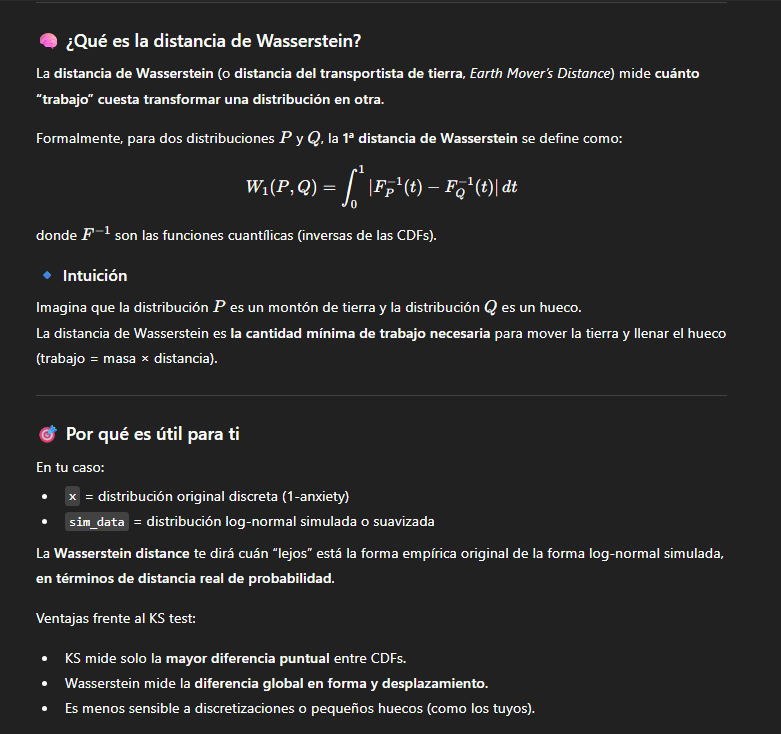

Parámetros lognorm -> shape=0.572146, loc=0.000000, scale=0.106041
KS test: D=0.0208, p=0.884616
Distancia de Wasserstein: 0.413552
Conclusión KS: Se ajusta bien (p>0.05)


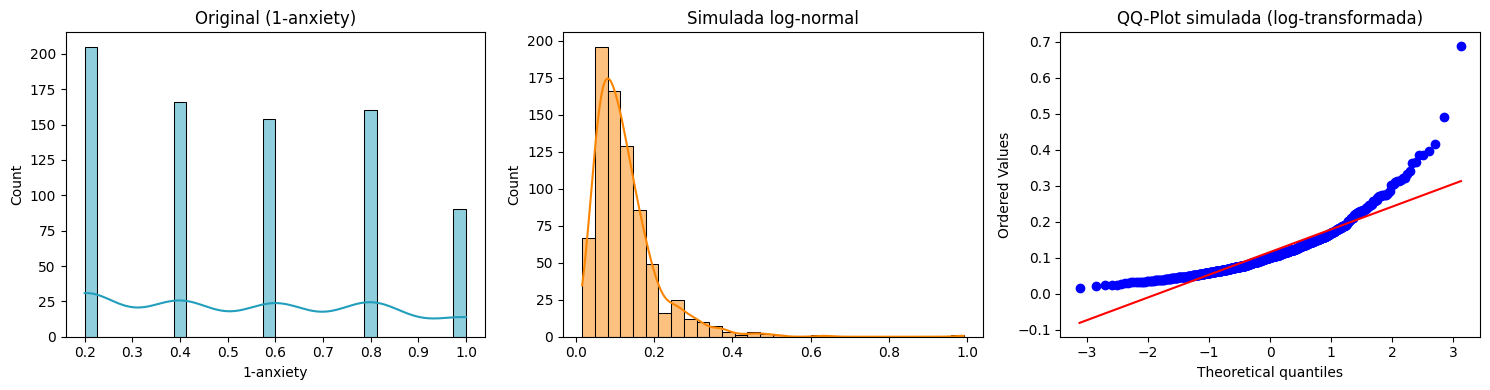

In [35]:
# =======================
# Cargar datos
# =======================
df = df_train.copy()
assert "1-anxiety" in df.columns, "No se encontró la columna '1-anxiety'"

# =======================
# Limpieza básica
# =======================
x = df["1-anxiety"].copy()
x = x.replace([np.inf, -np.inf], np.nan).dropna()
x = x[x > 0]

# =======================
# Corrección de huecos - Simulación log-normal
# =======================
shape, loc, scale = lognorm.fit(x, floc=0)
sim_data = lognorm.rvs(shape, loc, scale, size=len(x), random_state=42)
c = sim_data.max() / 0.99
sim_data = sim_data / c
sim_data = np.clip(sim_data, 1e-12, None)

# =======================
# Ajuste y pruebas
# =======================
shape2, loc2, scale2 = lognorm.fit(sim_data, floc=0)
D, p_val = kstest(sim_data, 'lognorm', args=(shape2, loc2, scale2))
wasserstein = wasserstein_distance(x, sim_data)

print(f"Parámetros lognorm -> shape={shape2:.6f}, loc={loc2:.6f}, scale={scale2:.6f}")
print(f"KS test: D={D:.4f}, p={p_val:.6f}")
print(f"Distancia de Wasserstein: {wasserstein:.6f}")
print("Conclusión KS:", "Se ajusta bien (p>0.05)" if p_val>0.05 else "No se ajusta (p<=0.05)")

# =======================
# Visualización
# =======================
fig, axes = plt.subplots(1, 3, figsize=(15,4))

sns.histplot(x, bins=30, kde=True, ax=axes[0], color="#219ebc")
axes[0].set_title("Original (1-anxiety)")

sns.histplot(sim_data, bins=30, kde=True, ax=axes[1], color="#fb8500")
axes[1].set_title("Simulada log-normal")

probplot(np.log1p(sim_data), dist="norm", plot=axes[2])
axes[2].set_title("QQ-Plot simulada (log-transformada)")

plt.tight_layout()
plt.show()


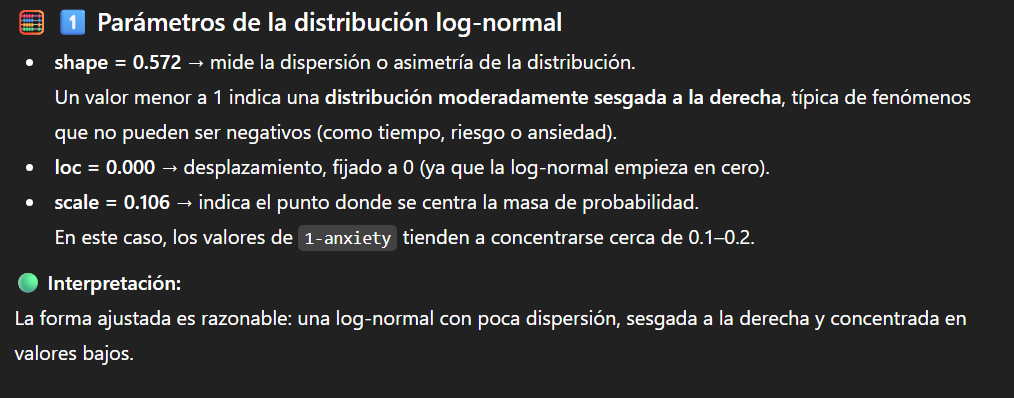

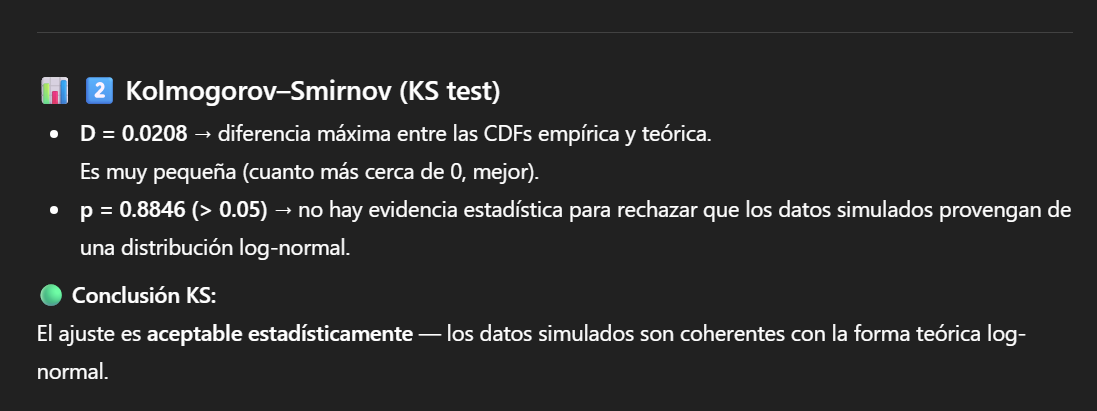

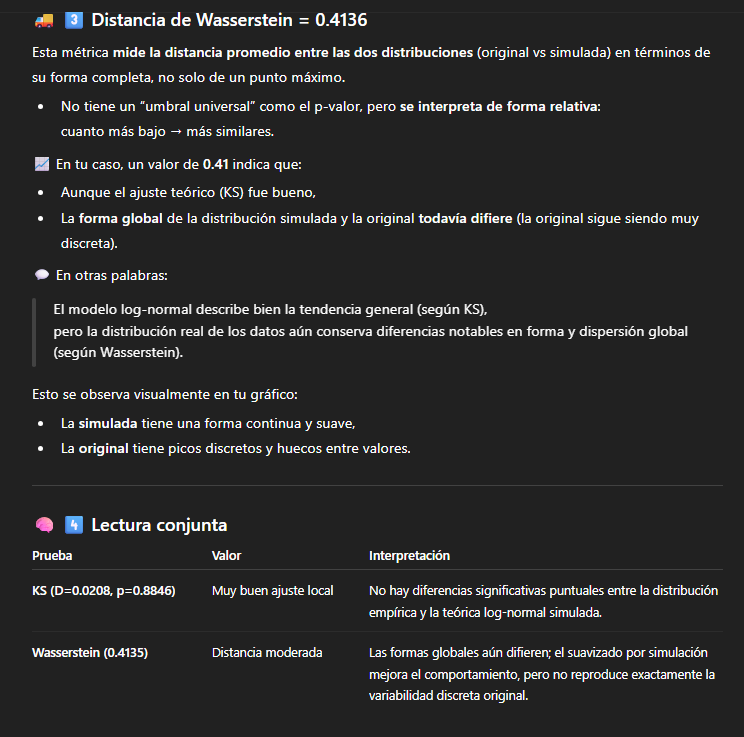

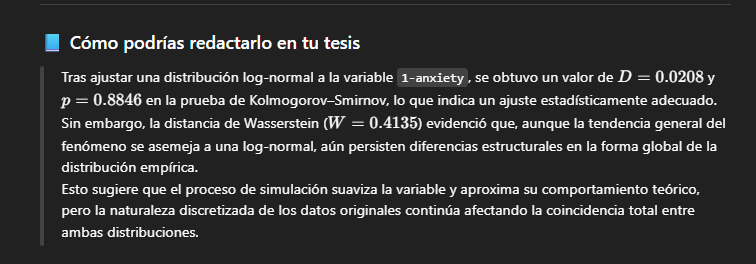

#### Distancia de Wassertein graficamente

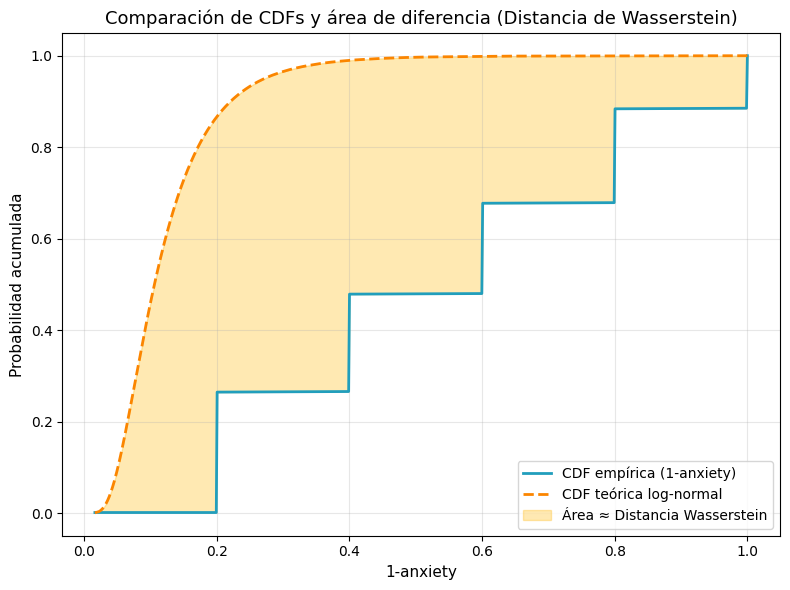

Área aproximada (distancia visual tipo Wasserstein): 0.4132


In [36]:
# ===================================
# Datos base
# ===================================
x_sorted = np.sort(x)
sim_sorted = np.sort(sim_data)

# ===================================
# Calcular CDFs
# ===================================
cdf_empirical = np.arange(1, len(x_sorted) + 1) / len(x_sorted)
cdf_theoretical = lognorm.cdf(sim_sorted, shape2, loc2, scale2)

# Igualar longitudes (por si acaso)
n = min(len(cdf_empirical), len(cdf_theoretical))
x_plot = np.linspace(min(x_sorted.min(), sim_sorted.min()),
                     max(x_sorted.max(), sim_sorted.max()), n)

cdf_emp_interp = np.interp(x_plot, x_sorted, cdf_empirical)
cdf_theo_interp = np.interp(x_plot, sim_sorted, cdf_theoretical)

# ===================================
# Calcular diferencia (área = distancia visual de Wasserstein)
# ===================================
diff = np.abs(cdf_emp_interp - cdf_theo_interp)

# ===================================
# Graficar CDFs con sombreado
# ===================================
plt.figure(figsize=(8,6))

# CDFs
plt.plot(x_plot, cdf_emp_interp, label="CDF empírica (1-anxiety)", color="#219ebc", linewidth=2)
plt.plot(x_plot, cdf_theo_interp, label="CDF teórica log-normal", color="#fb8500", linestyle="--", linewidth=2)

# Área sombreada entre ambas
plt.fill_between(x_plot, cdf_emp_interp, cdf_theo_interp, color="#ffb703", alpha=0.3, label="Área ≈ Distancia Wasserstein")

# Decoración
plt.title("Comparación de CDFs y área de diferencia (Distancia de Wasserstein)", fontsize=13)
plt.xlabel("1-anxiety", fontsize=11)
plt.ylabel("Probabilidad acumulada", fontsize=11)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ===================================
# Métrica numérica complementaria
# ===================================
wasserstein_area = np.trapz(diff, x_plot)
print(f"Área aproximada (distancia visual tipo Wasserstein): {wasserstein_area:.4f}")


#### Probado ajuste con distribuciones discretas

Wasserstein(empírica discreta vs log-normal simulada) = 0.060453


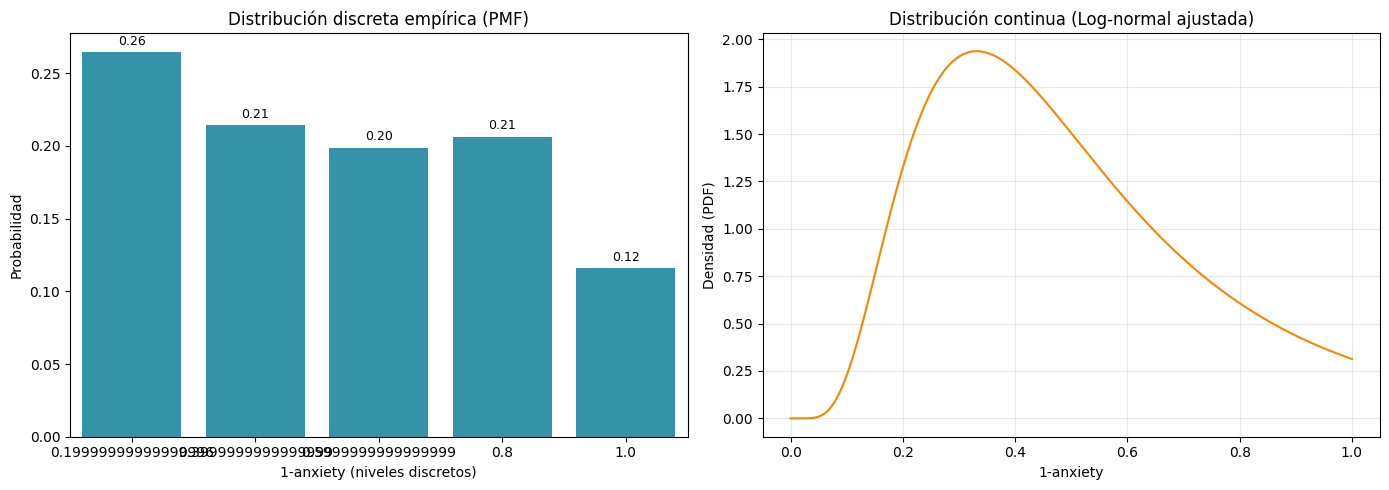

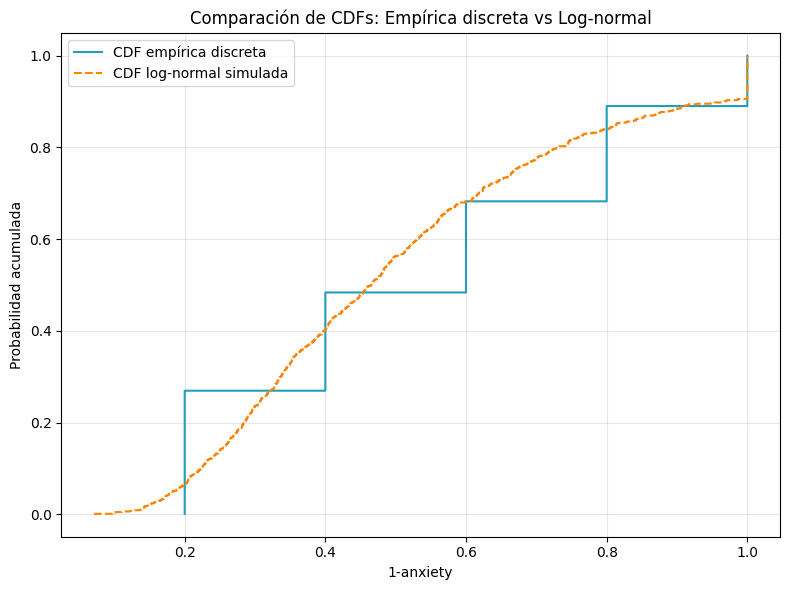


=== Estadísticos de la distribución discreta ===
Media empírica      = 0.5391
Varianza empírica   = 0.0740
Entropía (Shannon)  = 1.5787

=== Parámetros de la distribución discreta empírica ===
niveles      = [0.2 0.4 0.6 0.8 1. ]
pmf          = [0.2645 0.2142 0.1987 0.2065 0.1161]
media        = 0.539097
varianza     = 0.074020
entropía     = 1.578659
q05/q50/q95  = 0.200000 / 0.600000 / 1.000000

=== Parámetros de la log-normal (scipy) ===
shape (sigma)= 0.578720
loc          = 0.000000
scale=exp(mu)= 0.463217  -> mu=-0.769560
media        = 0.547659
mediana      = 0.463217
moda         = 0.331384
varianza     = 0.119320
q05/q50/q95  = 0.178803 / 0.463217 / 1.200034
(truncados a [0,1]) q05/q50/q95 = 0.178803 / 0.463217 / 1.000000

=== Media de VaR en niveles específicos ===
Alphas: [0.95]
Discreta empírica  -> VaR(alphas) = [1.] | media VaR = 1.000000
Log-normal (raw)   -> VaR(alphas) = [1.200034] | media VaR = 1.200034
Log-normal (clip)  -> VaR(alphas) = [1.]  | media VaR = 1.000000

In [37]:
# ======================================================
# Paso 1: Distribución discreta empírica vs Log-normal
# ======================================================


# =======================
# 1Cargar y limpiar
# =======================
df = df_train.copy()
assert "1-anxiety" in df.columns, "No se encontró la columna '1-anxiety'"

x = df["1-anxiety"].copy()
x = x.replace([np.inf, -np.inf], np.nan).dropna()
x = x[x > 0].astype(float)
x = np.clip(x, 1e-12, 1.0)

# =======================
# Distribución discreta empírica
# =======================
val_counts = x.value_counts(normalize=True).sort_index()
pmf = val_counts.values
levels = val_counts.index.values

# =======================
# Ajuste log-normal continuo (solo comparativo)
# =======================
shape, loc, scale = lognorm.fit(x, floc=0)
grid = np.linspace(0, 1, 500)
pdf_logn = lognorm.pdf(grid, shape, loc, scale)
pdf_logn /= np.trapz(pdf_logn, grid)  # normalizar área a 1

# Simulación log-normal para CDF comparada
sim_logn = np.clip(lognorm.rvs(shape, loc, scale, size=len(x), random_state=42), 0, 1)

# =======================
# Métricas comparativas
# =======================
# Empírica discreta (PMF) → simular una "muestra" según las proporciones
rng = np.random.default_rng(42)
sim_emp = rng.choice(levels, size=len(x), p=pmf)

W_emp_logn = wasserstein_distance(sim_emp, sim_logn)
print(f"Wasserstein(empírica discreta vs log-normal simulada) = {W_emp_logn:.6f}")

# =======================
# Visualización: PMF vs PDF
# =======================
fig, ax = plt.subplots(1, 2, figsize=(14,5))

# --- Izquierda: PMF discreta
sns.barplot(x=levels, y=pmf, color="#219ebc", ax=ax[0])
ax[0].set_title("Distribución discreta empírica (PMF)")
ax[0].set_xlabel("1-anxiety (niveles discretos)")
ax[0].set_ylabel("Probabilidad")
for i, (lvl, p) in enumerate(zip(levels, pmf)):
    ax[0].text(i, p + 0.005, f"{p:.2f}", ha='center', fontsize=9)

# --- Derecha: PDF log-normal ajustada
sns.lineplot(x=grid, y=pdf_logn, ax=ax[1], color="#fb8500")
ax[1].set_title("Distribución continua (Log-normal ajustada)")
ax[1].set_xlabel("1-anxiety")
ax[1].set_ylabel("Densidad (PDF)")
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# =======================
# CDFs comparadas
# =======================
def ecdf(arr):
    s = np.sort(arr)
    F = np.arange(1, len(s)+1)/len(s)
    return s, F

# ECDF discreta
x_emp, F_emp = ecdf(sim_emp)
# ECDF log-normal simulada
x_logn, F_logn = ecdf(sim_logn)

plt.figure(figsize=(8,6))
plt.step(x_emp, F_emp, where="post", label="CDF empírica discreta", color="#219ebc")
plt.step(x_logn, F_logn, where="post", label="CDF log-normal simulada", color="#fb8500", linestyle="--")
plt.title("Comparación de CDFs: Empírica discreta vs Log-normal")
plt.xlabel("1-anxiety")
plt.ylabel("Probabilidad acumulada")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.show()

# =======================
# Métricas adicionales (resumen)
# =======================
entropy = -np.sum(pmf * np.log(pmf + 1e-12))
mean_emp = np.sum(pmf * levels)
var_emp = np.sum(pmf * (levels - mean_emp)**2)
print("\n=== Estadísticos de la distribución discreta ===")
print(f"Media empírica      = {mean_emp:.4f}")
print(f"Varianza empírica   = {var_emp:.4f}")
print(f"Entropía (Shannon)  = {entropy:.4f}")


# =======================
# Parámetros y resumen de cada distribución
# =======================


# ---- Utilidades ----
def weighted_quantile(values, probs, q):
    """
    Cuantil ponderado para distribución discreta:
    values = niveles (ordenados asc)
    probs  = pmf (mismas longitudes, suman 1)
    q en [0,1]
    """
    order = np.argsort(values)
    v = np.asarray(values)[order]
    p = np.asarray(probs)[order]
    F = np.cumsum(p)
    return v[np.searchsorted(F, q, side="left")]

# ----  Parámetros de la distribución discreta empírica ----
disc_mean = np.sum(levels * pmf)
disc_var  = np.sum(pmf * (levels - disc_mean)**2)
disc_entropy = -np.sum(pmf * np.log(pmf + 1e-12))

disc_q05 = weighted_quantile(levels, pmf, 0.05)
disc_q50 = weighted_quantile(levels, pmf, 0.50)  # mediana
disc_q95 = weighted_quantile(levels, pmf, 0.95)  # VaR 95%

# ---- Parámetros de la log-normal (ajustada antes con: shape, loc, scale) ----
# En scipy.lognorm: shape = sigma, scale = exp(mu), loc (aquí = 0)
mu_hat = np.log(scale)
sigma_hat = shape

# Momentos teóricos (para loc=0)
ln_mean = np.exp(mu_hat + 0.5 * sigma_hat**2)
ln_median = np.exp(mu_hat)
ln_mode = np.exp(mu_hat - sigma_hat**2)
ln_var = (np.exp(sigma_hat**2) - 1.0) * np.exp(2*mu_hat + sigma_hat**2)

# Cuantiles teóricos (ojo: pueden exceder 1 si luego tú recortas a [0,1])
ln_q05 = lognorm.ppf(0.05, s=sigma_hat, loc=loc, scale=scale)
ln_q50 = lognorm.ppf(0.50, s=sigma_hat, loc=loc, scale=scale)
ln_q95 = lognorm.ppf(0.95, s=sigma_hat, loc=loc, scale=scale)

# Cuantiles "truncados" a [0,1] si quieres reportarlos consistentes con tu soporte
ln_q05_tr = np.clip(ln_q05, 0, 1)
ln_q50_tr = np.clip(ln_q50, 0, 1)
ln_q95_tr = np.clip(ln_q95, 0, 1)

# ---- Tabla resumen ----
resumen = pd.DataFrame({
    "Distribución": ["Discreta empírica", "Log-normal (teórica)"],
    "Soporte": ["{niveles fijos}", "(0,∞)"],
    "Parámetros": [
        f"niveles={np.round(levels,3).tolist()}, pmf={np.round(pmf,3).tolist()}",
        f"sigma={sigma_hat:.4f}, loc={loc:.4f}, scale={scale:.4f} (mu={mu_hat:.4f})"
    ],
    "Media": [disc_mean, ln_mean],
    "Mediana": [disc_q50, ln_median],
    "Moda": [levels[np.argmax(pmf)], ln_mode],
    "Varianza": [disc_var, ln_var],
    "VaR 95% (q0.95)": [disc_q95, ln_q95],
    "VaR 95% truncado [0,1]": [disc_q95, ln_q95_tr],
})

print("\n=== Parámetros de la distribución discreta empírica ===")
print(f"niveles      = {levels}")
print(f"pmf          = {np.round(pmf, 4)}")
print(f"media        = {disc_mean:.6f}")
print(f"varianza     = {disc_var:.6f}")
print(f"entropía     = {disc_entropy:.6f}")
print(f"q05/q50/q95  = {disc_q05:.6f} / {disc_q50:.6f} / {disc_q95:.6f}")

print("\n=== Parámetros de la log-normal (scipy) ===")
print(f"shape (sigma)= {sigma_hat:.6f}")
print(f"loc          = {loc:.6f}")
print(f"scale=exp(mu)= {scale:.6f}  -> mu={mu_hat:.6f}")
print(f"media        = {ln_mean:.6f}")
print(f"mediana      = {ln_median:.6f}")
print(f"moda         = {ln_mode:.6f}")
print(f"varianza     = {ln_var:.6f}")
print(f"q05/q50/q95  = {ln_q05:.6f} / {ln_q50:.6f} / {ln_q95:.6f}")
print(f"(truncados a [0,1]) q05/q50/q95 = {ln_q05_tr:.6f} / {ln_q50_tr:.6f} / {ln_q95_tr:.6f}")

try:
    from caas_jupyter_tools import display_dataframe_to_user
    display_dataframe_to_user("Resumen parámetros (Discreta vs Log-normal)", resumen)
except Exception:
    pass


# =======================
# Media de VaR (promedio de cuantiles en un conjunto de alphas)
# =======================

# Conjunto de niveles de confianza (ajústalos a tu gusto)
alphas = np.array([ 0.95])

def weighted_quantile(values, probs, q):
    order = np.argsort(values)
    v = np.asarray(values)[order]
    p = np.asarray(probs)[order]
    F = np.cumsum(p)
    return v[np.searchsorted(F, q, side="left")]

# --- VaR para la distribución discreta empírica ---
VaR_disc = np.array([weighted_quantile(levels, pmf, a) for a in alphas])
VaR_disc_mean = VaR_disc.mean()

# --- VaR para la log-normal (teórica) ---
VaR_logn_raw = lognorm.ppf(alphas, s=shape, loc=loc, scale=scale)
# Si quieres respetar el soporte (0,1], reporta también la versión truncada
VaR_logn_tr = np.clip(VaR_logn_raw, 0, 1)
VaR_logn_mean_raw = VaR_logn_raw.mean()
VaR_logn_mean_tr  = VaR_logn_tr.mean()

print("\n=== Media de VaR en niveles específicos ===")
print(f"Alphas: {alphas}")
print(f"Discreta empírica  -> VaR(alphas) = {np.round(VaR_disc, 6)} | media VaR = {VaR_disc_mean:.6f}")
print(f"Log-normal (raw)   -> VaR(alphas) = {np.round(VaR_logn_raw, 6)} | media VaR = {VaR_logn_mean_raw:.6f}")
print(f"Log-normal (clip)  -> VaR(alphas) = {np.round(VaR_logn_tr, 6)}  | media VaR = {VaR_logn_mean_tr:.6f}")

# --- Media integral del VaR (promedio sobre alpha en [0,1]) ---
# Por teoría, esto coincide con la media de la distribución:
print("\n=== Media integral de VaR (∫_0^1 VaR dα) ===")
print(f"Discreta empírica  -> media integral VaR = {mean_emp:.6f}  (igual a la media empírica)")
print(f"Log-normal (teórica)-> media integral VaR = {ln_mean:.6f} (igual a la media teórica)")



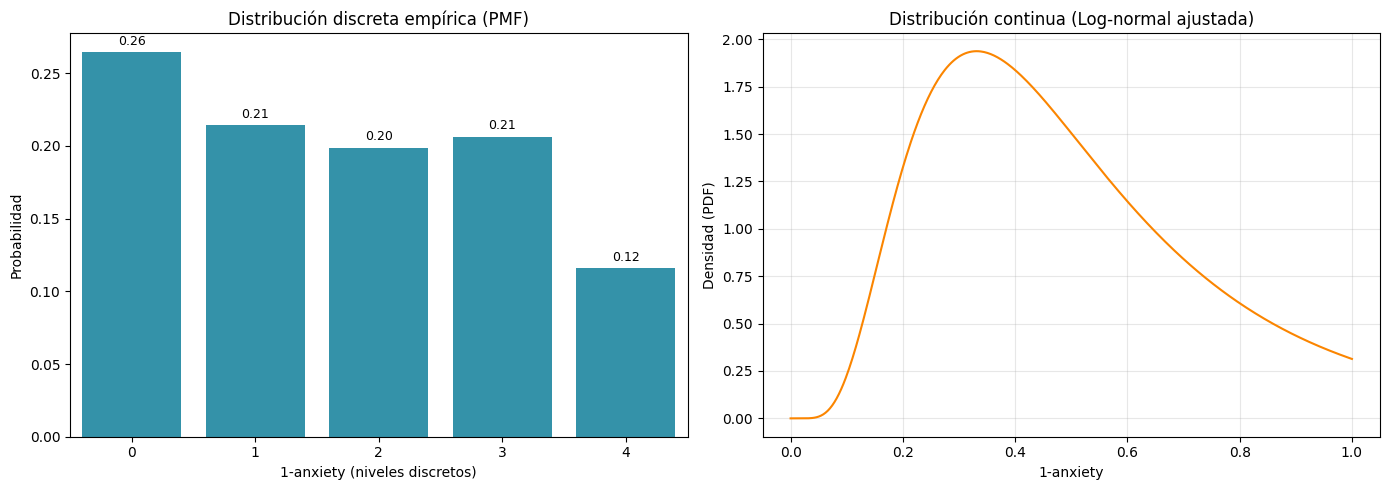

<Axes: title={'center': 'Distribución discreta empírica (PMF)'}, xlabel='1-anxiety (niveles discretos)', ylabel='Probabilidad'>

In [38]:
# =======================
# Visualización: PMF vs PDF

# =======================

from matplotlib.ticker import FuncFormatter  

fig, ax = plt.subplots(1, 2, figsize=(14,5))


# --- Izquierda: PMF discreta
sns.barplot(x=levels, y=pmf, color="#219ebc", ax=ax[0])
ax[0].set_title("Distribución discreta empírica (PMF)")
ax[0].set_xlabel("1-anxiety (niveles discretos)")
ax[0].set_ylabel("Probabilidad")
ax[0].xaxis.set_major_formatter(
    FuncFormatter(lambda val, _: f"{val:.2f}".rstrip("0").rstrip("."))
)
for i, (lvl, p) in enumerate(zip(levels, pmf)):
    ax[0].text(i, p + 0.005, f"{p:.2f}", ha="center", fontsize=9)

    

# --- Derecha: PDF log-normal ajustada
sns.lineplot(x=grid, y=pdf_logn, ax=ax[1], color="#fb8500")
ax[1].set_title("Distribución continua (Log-normal ajustada)")
ax[1].set_xlabel("1-anxiety")
ax[1].set_ylabel("Densidad (PDF)")
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()




sns.barplot(x=levels, y=pmf, color="#219ebc", ax=ax[0])

# …configuración existente…





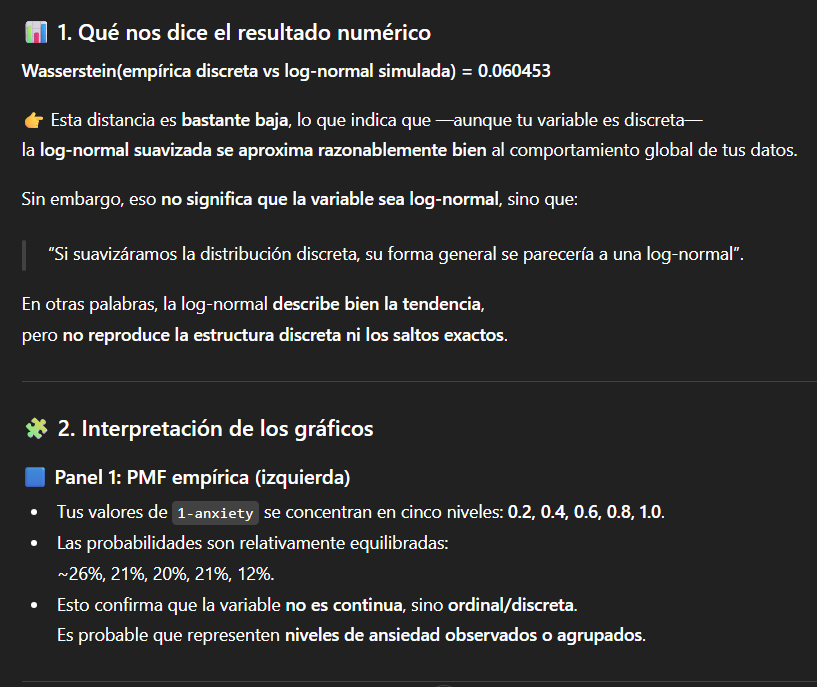

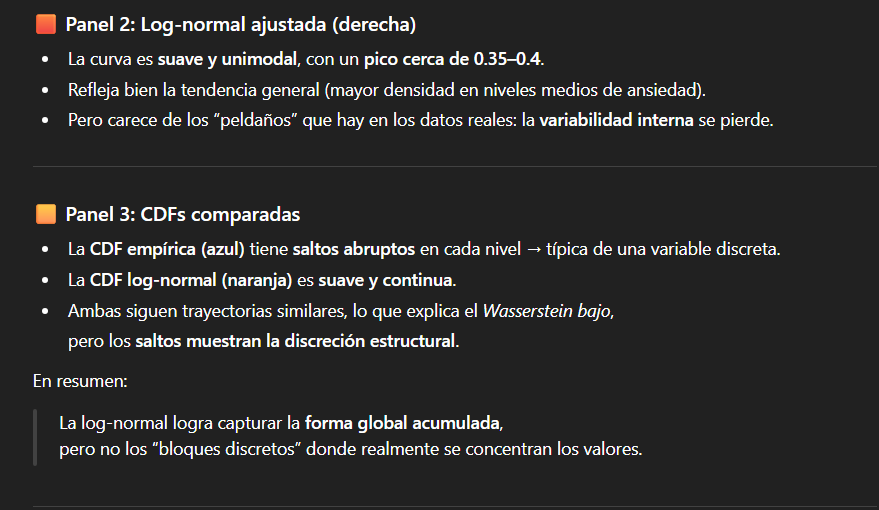

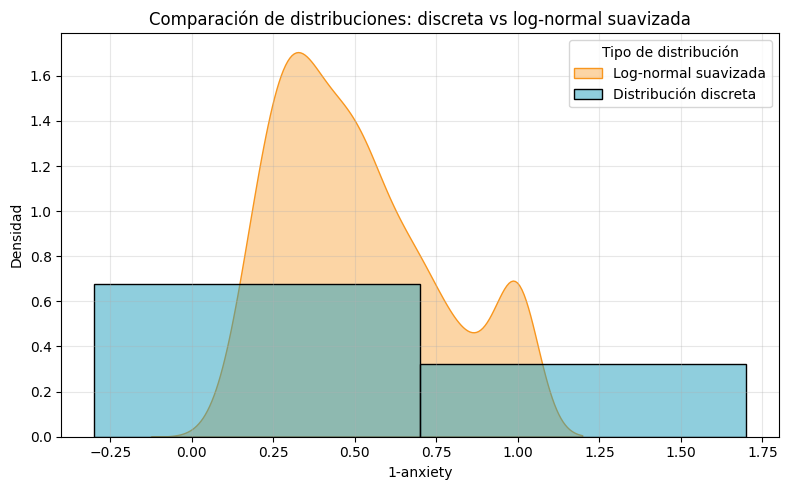

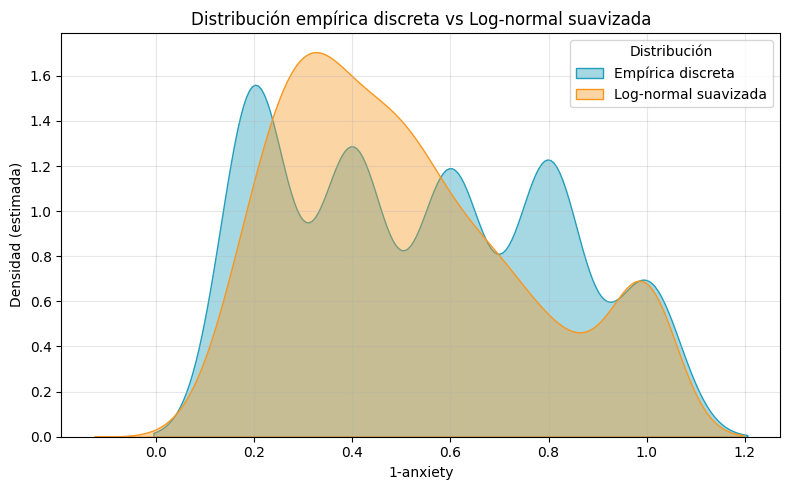

In [39]:
# ======================================================
# Comparación visual: Distribución discreta vs Log-normal suavizada
# ======================================================


# --- Datos base (usa los que ya tienes) ---
x = df_train["1-anxiety"].replace([np.inf, -np.inf], np.nan).dropna().astype(float)
x = x[x > 0]
x = np.clip(x, 1e-12, 1.0)

# --- PMF discreta ---
val_counts = x.value_counts(normalize=True).sort_index()
levels = val_counts.index.values
pmf = val_counts.values

# --- Log-normal suavizada ---
shape, loc, scale = lognorm.fit(x, floc=0)
sim_logn = np.clip(lognorm.rvs(shape, loc, scale, size=len(x), random_state=42), 0, 1)

# ======================================================
# Comparación tipo KDE (suavizada)
# ======================================================

plt.figure(figsize=(8,5))
sns.kdeplot(sim_logn, fill=True, alpha=0.4, color="#f8961e", label="Log-normal suavizada")
sns.histplot(x, bins=len(levels), stat="density", discrete=True,
             color="#219ebc", alpha=0.5, label="Distribución discreta")

plt.title("Comparación de distribuciones: discreta vs log-normal suavizada")
plt.xlabel("1-anxiety")
plt.ylabel("Densidad")
plt.legend(title="Tipo de distribución")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ======================================================
# versión tipo “overlap” 
# ======================================================

# Convertimos la discreta a formato expandido para graficar “suavizada”
empirical_expanded = np.repeat(levels, (pmf * 1000).astype(int))  # simula 1000 observaciones

plt.figure(figsize=(8,5))
sns.kdeplot(empirical_expanded, fill=True, color="#219ebc", alpha=0.4, label="Empírica discreta")
sns.kdeplot(sim_logn, fill=True, color="#f8961e", alpha=0.4, label="Log-normal suavizada")

plt.title("Distribución empírica discreta vs Log-normal suavizada")
plt.xlabel("1-anxiety")
plt.ylabel("Densidad (estimada)")
plt.legend(title="Distribución")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Analisis de Distribucion lognormal ajustada vs VaR

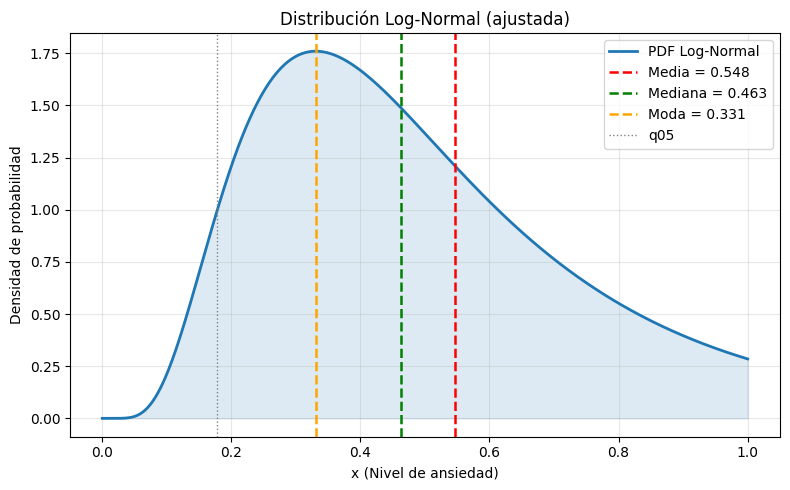

In [44]:
# ========================
# Parámetros de la log-normal
# ========================
shape = 0.578720     # sigma
loc = 0.0
scale = 0.463217     # exp(mu)
mu = -0.769560

# ========================
# Distribución
# ========================
x = np.linspace(0.001, 1, 500)
pdf = lognorm.pdf(x, s=shape, loc=loc, scale=scale)

# Cuantiles y estadísticas
mean = 0.547659
median = 0.463217
mode = 0.331384
q05, q50, q95 = 0.178803, 0.463217, 1.0

# ========================
# Gráfica
# ========================
plt.figure(figsize=(8,5))
plt.plot(x, pdf, color="#1f77b4", lw=2, label="PDF Log-Normal")
plt.fill_between(x, pdf, color="#1f77b4", alpha=0.15)

# Líneas verticales
plt.axvline(mean, color="red", linestyle="--", lw=1.8, label=f"Media = {mean:.3f}")
plt.axvline(median, color="green", linestyle="--", lw=1.8, label=f"Mediana = {median:.3f}")
plt.axvline(mode, color="orange", linestyle="--", lw=1.8, label=f"Moda = {mode:.3f}")
plt.axvline(q05, color="gray", linestyle=":", lw=1, label="q05")


# Etiquetas
plt.title("Distribución Log-Normal (ajustada)")
plt.xlabel("x (Nivel de ansiedad)")
plt.ylabel("Densidad de probabilidad")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


VaR_0.05 (no truncado) = 0.178803
VaR_0.05 (truncado)    = 0.178803
P(X <= VaR | truncado) ≈ 0.055054
CVaR/ES_0.05 (truncado) ≈ 0.143555


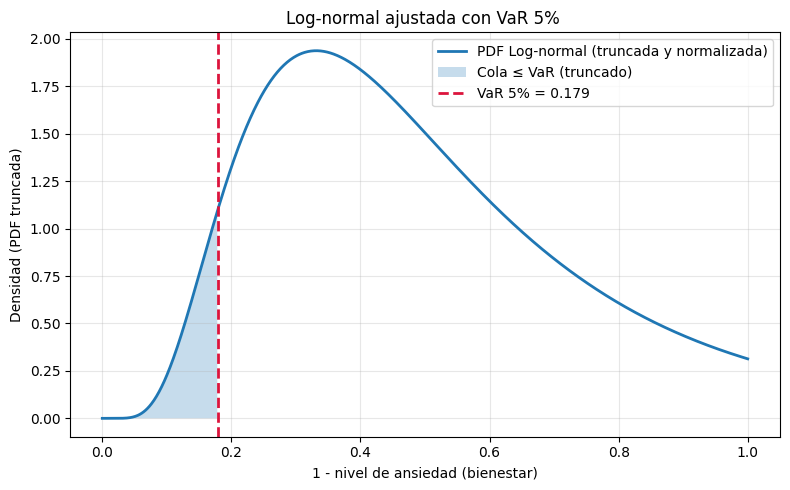

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# --- parámetros ya estimados ---
s = shape  # shape
# loc, scale: también ya estimados

# --- grid y pdf*normalizada en [0,1] ---
xg = np.linspace(0, 1, 1000)
pdf = lognorm.pdf(xg, s=s, loc=loc, scale=scale)
area = np.trapz(pdf, xg)
pdf_t = pdf / area  # pdf truncada (renormalizada)

# ============================================================
# 1. VaR en la COLA IZQUIERDA (percentil 5%)
# ============================================================
alpha_left = 0.05

# VaR sin truncar
VaR_left_raw = lognorm.ppf(alpha_left, s=s, loc=loc, scale=scale)

# VaR truncado a [0,1]
VaR_left_tr = np.clip(VaR_left_raw, 0, 1)

# Probabilidad de estar por DEBAJO del VaR en el modelo truncado
F0 = lognorm.cdf(0, s=s, loc=loc, scale=scale)
Fv_left = lognorm.cdf(VaR_left_tr, s=s, loc=loc, scale=scale)
Z = max(F1 - F0, 1e-16)  # normalización en [0,1]
tail_prob_left_tr = (Fv_left - F0) / Z

print(f"VaR_0.05 (no truncado) = {VaR_left_raw:.6f}")
print(f"VaR_0.05 (truncado)    = {VaR_left_tr:.6f}")
print(f"P(X <= VaR | truncado) ≈ {tail_prob_left_tr:.6f}")

# ============================================================
# 2. CVaR (Expected Shortfall) izquierdo por simulación truncada
# ============================================================
rng = np.random.default_rng(7)
sim = np.clip(lognorm.rvs(s=s, loc=loc, scale=scale, size=200_000), 0, 1)

ES_left_tr = sim[sim <= VaR_left_tr].mean() if np.any(sim <= VaR_left_tr) else VaR_left_tr
print(f"CVaR/ES_0.05 (truncado) ≈ {ES_left_tr:.6f}")

# ============================================================
# 3. Gráfica con VaR y cola izquierda sombreada
# ============================================================
plt.figure(figsize=(8,5))
plt.plot(xg, pdf_t, lw=2, label="PDF Log-normal (truncada y normalizada)")

# sombreado izquierda
plt.fill_between(xg, pdf_t, where=(xg <= VaR_left_tr), alpha=0.25,
                 label="Cola ≤ VaR (truncado)")

plt.axvline(VaR_left_tr, color="crimson", linestyle="--", lw=2,
            label=f"VaR 5% = {VaR_left_tr:.3f}")

plt.title("Log-normal ajustada con VaR 5% ")
plt.xlabel("1 - nivel de ansiedad (bienestar)")
plt.ylabel("Densidad (PDF truncada)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
